In [42]:
# import the required libraries

import matplotlib.pyplot as plt

import matplotlib.image as image

import numpy as np

import pandas

import scipy

import scipy.signal

import os

from cycler import cycler

import datetime

import uncertainties

import uncertainties.unumpy

import pytesseract

import cv2

In [43]:
#defining global variables
R = 8.31446261815324

boxvol = 0.000738 #in cubic meters

voltages = [4.36,4.82,5.24,5.62,5.99]

#just for reference purposes
units = {
    "mass" : "mg",
    "voltage" : "V",
    "current" : "mA",
    "resistance" : "Ohm",
    "power" : "W",
    "humidity" : "%",
    "airTemp" : "°C",
    "pressure" : "Pa",
    "numCO2" : "mol",
    "energy" : "J"
        }

parametersRef = {
    "mass" : "?",
    "restTime" : "?",
    "folderName" : "?"
}

In [44]:
# defining the function used to read the data from the potentiostat
# it takes one input: a list of file names (these should be text files)
# the file names should include their entire path as well: r"C:\Users\Kepler\Documents\Summer Project\Data\Test1" rather than "Test1"
# this function will be needed for almost all other functions
# it gives one output: a dictionary containing:
#       a list of times, a list of voltages, a list of currents, a list of resistances, a list of powers, and also the full dataset

def readPotentiostat(file_names):

    #defining the dictionary that we're going to add to
    output_dictionary = {}

    #reading the files given
    read_values = [pandas.read_csv(file,usecols=[0,1,2,3], sep = '\t',header=0).rename( columns={"I/mA": "<I>/mA"}) for file in file_names]

    potentiostat_data = pandas.concat(read_values,ignore_index=True)    
    
    #splitting the data into its components
    output_dictionary["potentiostat_time"] = pandas.to_datetime(potentiostat_data["time/s"], format="%m/%d/%Y %H:%M:%S.%f")

    output_dictionary["voltage"] = potentiostat_data["Ewe/V"]

    output_dictionary["current"] = potentiostat_data["<I>/mA"]

    #calculating secondary information
    output_dictionary["resistance"] = [V/ (I/1000) if V>0.1 and I>0 else 0 for V,I in zip(output_dictionary["voltage"],output_dictionary["current"])]

    output_dictionary["power"] = [V*(I/1000) if V>0.1 else 0 for V,I in zip(output_dictionary["voltage"],output_dictionary["current"])]
    
    #also just the whole dataset why not
    output_dictionary["full_panda"] = potentiostat_data
    

    return output_dictionary

In [46]:
# defining the function used to read the aranet data
# it takes one input, a single file path (please include the whole path) (i think this is a csv file normally)
# it outputs a dictionary containing:
#      a list of times, a list of CO2 ppms, a list of (relative) humidities, a list of air temperatures, a list of air pressures, and a list of the number of mols of co2 in the box
def readAranet(file_name):
    
    #defining the dictionary that we're going to add to
    output_dictionary = {}

    #reading the data
    aranet_data = pandas.read_csv(file_name, sep=",",header=0)
    
    #splitting the data into its components
    output_dictionary["aranet_time"] = pandas.to_datetime(aranet_data["Time(dd/mm/yyyy)"], format="%d/%m/%Y %H:%M:%S")

    output_dictionary["ppm"] = aranet_data["Carbon dioxide(ppm)"]

    output_dictionary["humidity"] = aranet_data["Relative humidity(%)"]

    output_dictionary["air_temperature"] = aranet_data["Temperature(°C)"]
    
    #calculating secondary information, this section used to include absolute water in the box, but that was difficult and never got used, so it was removed. feel free to add it back in
    output_dictionary["pressure"] = [pressure * 100 for pressure in aranet_data["Atmospheric pressure(hPa)"]]

    output_dictionary["amount_CO2"] = [P * (ppm/1000000) * boxvol / (R * (T+273.15)) for P,ppm,T in zip(output_dictionary["pressure"], output_dictionary["ppm"], output_dictionary["air_temperature"])]
    

    return output_dictionary

In [47]:
#function to read the temperature data
#it theoretically takes a bunch of inputs, but only two are needed
    #file_path: the path to the video file
    #interval: how often you want to read the data (in seconds) !WARNING! this will dramatically impact how long the function will take. on my computer, setting this to 1 requires 4 hours of runtime
    #crop??: the bounding box of the part of the video with information. automatically set to the default assuming the camera is reporting on two points, tinker with this if that's not true
    #watch_video: there's a little animation as the function reads through the 24 hour video which i quite like, turn it off by setting this to False
#this function does not require any previous functions, but does need you to have imported numpy (as np), pandas, cv2, os, and pytesseract
#if you need help setting up pytesseract and im still around, please email me. if im not then set aside a couple hours and look it up
#this function outputs a dictionary, but also a text file. If possible, use the text file so that the function doesnt have to run everytime you decide to draw a graph, and only needs to be run once

#on my home computer, tesseract suddenly lost privileges. i do not know what caused that, but this is the workaround
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def readFLIR(file_path, interval, cropX1 = 60, cropY1 = 20, cropX2 = 119, cropY2 = 100, watch_video = True):

    output_dictionary = {}

    #takes the input video
    input_video = cv2.VideoCapture(file_path)

    #makes an output text file
    folder = os.path.dirname(file_path)
    output_path = os.path.join(folder, "temperature data raw.txt")
    
    #grabs a bunch of random data, some of which will get used
    width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = input_video.get(cv2.CAP_PROP_FPS)
    numberFrames = int(input_video.get(cv2.CAP_PROP_FRAME_COUNT))

    #output video doesn't work in my testing sheet, idk why but it also is not super important so its fine. leaving the bones of it around so it can be fixed by someone smarter
    #fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #output_video = cv2.VideoWriter(r"/media/kp556/thlirth/Summer Project/Sample 2\output_video.mp4',fourcc, fps, (x2 - x1, y2 - y1))

    #the interval specified in units of frames
    real_interval = interval*fps

    #need to initialise the array because arrays are more efficient than lists and this function needs as much efficiency as it can get
    array_raw = np.zeros(int((numberFrames-(numberFrames%real_interval))/(real_interval))+1, dtype = object)
    frames_capped = np.zeros(int((numberFrames-(numberFrames%real_interval))/(real_interval))+1, dtype = object)

    counter = 0 #I know this is inelegent but i think enummerating the np array will be slower and cant think of a better way to do this


    #iterate through all selected frames
    for observed_frame in array_raw:

        print(counter)
        
        #read the current frame
        int_frame = int(1+real_interval*counter)
        input_video.set(1,int_frame)
        ret,frame = input_video.read()

        frames_capped[counter] = int_frame
        #if the current frame does not exist
        if not ret:
            break
    
        #crop the frame
        cropped_frame = frame[cropY1:cropY2, cropX1:cropX2]
    
        #make it grayscale
        gray_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
    
        #invert it
        inverted_frame = np.invert(gray_frame)
    
        #contrast it
        contrasted_frame = cv2.convertScaleAbs(inverted_frame, alpha=5, beta=-50) 
        
        #read the frame
        temperature_raw = pytesseract.image_to_string(contrasted_frame, config = "-c tessedit_char_whitelist=0123456789.")
        array_raw[counter] = temperature_raw
        
        #write the cropped frame to the output video. this is the part that doesnt work i think
        #output_video.write(contrasted_frame)
    
        #display the cropped frame (optional)
        if watch_video:
            cv2.imshow('Cropped Video', contrasted_frame)
    
        counter += 1
        
        #exit if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    #release the input and output videos and close the display window
    input_video.release()
    #output_video.release()
    cv2.destroyAllWindows()

    list_split = []
    list_data = []
    time = []

    #pytesseract outputs strings, and in the case of the camera data, these strings will be two (or 1 or 3) lines both ending in \n (new line). we need to split these into seperate values then convert those values to numbers
    for index, data_point in np.ndenumerate(array_raw):

        #sometimes it fails to parse the text, we will just ignore those datapoints
        try:
            list_split.append(data_point.split("\n"))
            del list_split[-1][-1]

        
            final_split = [float(string) for string in list_split[-1]]

            # the camera can only read up to 150 *C, if the function reads a number higher than that, it did it wrong: ignore this datapoint, go to the next value
            if all(numbers <= 150 for numbers in final_split) and len(final_split) ==2:
                list_data.append(final_split)

                #the + 3600 comes from the fact that I am writing this in summertime, and am thus on BST, please remove in winter. 
                #this is wrong i think, but have included it in all runs so far so keeping it consistent. just remember to check for off by 3600 errors either way
                time.append(os.path.getmtime(file_path)+3600 - numberFrames/fps + frames_capped[index]/fps)
        except:
            #lol
            print("lol")
       
        
    #outputting to both the output dictionary and the text file
    #using try and except because there will be points it has failed to parse correctly that made it this far. luckily we have many many points so losing a few to this is not a problem
    try:
        output_dataframe = pandas.DataFrame(data = [time, [x[-1] for x in list_data]]).T
        output_dictionary["temperature"] = list_data
        output_dictionary["time"] = time
        output_dataframe.columns = ["time","temperature"]
        output_dataframe.to_csv(output_path, sep = "\t")    
    except:
        #lmao
        print("lmao")

    return output_dictionary

In [48]:
#uneeded and deletable, attempted fix for the faulty IR camera framerate issues

def squeezeTemp(path_video, path_data,offset = 0):
    end_time = os.path.getmtime(path_video)+3600+offset
    video = cv2.VideoCapture(path_video)
    video_length = video.get(cv2.CAP_PROP_FRAME_COUNT)/ video.get(cv2.CAP_PROP_FPS)

    data = pandas.read_csv(path_data, sep = "\t", header = 0)
    time_data = np.array(data["time"])
    temp_data = np.array(data["temperature"])
    apparant_length = time_data[-1]-time_data[0]
    check_offset = time_data[-1]-end_time
    print(check_offset, "offset")
    print(video_length, "lenghth")
    print(apparant_length)

    ratio = video_length/apparant_length

    squeezed_time = [(original_time-end_time)*ratio+end_time for original_time in time_data]
    return {"time" : squeezed_time, "temperature" : temp_data}

#print(squeezeTemp('/media/kp556/thlirth/Summer Project/Sample 5.4/rec_0003.avi','/media/kp556/thlirth/Summer Project/Sample 5.4/temperature data raw.txt' ))

In [50]:
#noise cancelling
#there are several sources of noise in the temperature data, from improperly read numbers to (most embarrassingly) the function reading the charge on the battery as the temperature after calibrating
#in the future, it may be a good idea to include this functionality into the readFlir function, but i won't do that now

#the function takes the raw temp data file created by readFlir, but does not require any previous functions to have been defined.
#the function outputs a tuple containing: the array of filtered temperatures, the corresponding array of times, the array of peaks removed sorted by method of removal, the original array of temperatures, and the corresponding original array of times

#the "videopath" stuff is to mesh with the above sqeeze temp. can be removed
def noiseRemove(temp_path, video_path=False,offset = 0):

    #the first step is, as always, to get the data
    if not video_path:
        temp_data = pandas.read_csv(temp_path, header = 0, sep = "\t")
    else:

        temp_data = squeezeTemp(video_path, temp_path,offset)

    #now we seperate the data into temperature and time
    temp_temp = np.array(temp_data["temperature"])
    temp_time = np.array(temp_data["time"])
    
    #due to the peakfinding algorithm used (scipy.signal.find_peaks), I found it easiest to make an array of the negative temperatures to find the troughs. there may be a more elegant way
    temp_temp2 = [-temp for temp in temp_temp]
    
    #finding the peaks. the threshold is lower on the upwards peaks as they are more critical to find.
    peaks_down = scipy.signal.find_peaks(temp_temp2, threshold= 2)
    peaks_up = scipy.signal.find_peaks(temp_temp, threshold=1)

    #this finds the peaks caused by the camera battery notices. it (inelegantly) removes all whole numbers under 100, as the camera outputs to three significant figures and the battery notices only provide two.
    #noteably, this *will* produce false positives but the effect of those will be to reduce one in ten of the measured peak temperatures by 0.1 degrees. this is a price worth paying.
    peaks_battery = np.where((temp_temp%1== 0) & (temp_temp<100))[0]
    
    #go through and remove any flagged peaks
    removed_peaks_temp = np.delete(temp_temp, np.concatenate((peaks_battery,peaks_down[0],peaks_up[0])))
    removed_peaks_time = np.delete(temp_time, np.concatenate((peaks_battery,peaks_down[0],peaks_up[0])))

    #output the tuple mentioned above
    return(removed_peaks_temp,removed_peaks_time,[peaks_down, peaks_up, peaks_battery], temp_temp,temp_time)




In [51]:
# defining the function that detects the edge of voltage holds
# this function takes a dictionary of the files such as outputted by readPotentiostat or unstripe
# this function *also* outputs a dictionary (I like dictionaries ok?) containing:
#    a list of numerical positions where the voltage is turned on, a similar list for when the voltage is turned off, a list of times where the voltage is turned on, and a similar list for when its turned off

def edgeFind(input_dictionary):


    #as always, an output dictionary is defined
    output_dictionary = {}

    #this time, we also define some lists that will be included in the output, this is because .append() is very convenient to use and requires a list to exist
    potentiostat_position_ON = []

    potentiostat_position_OFF = []

    potentiostat_time_ON = []

    potentiostat_time_OFF = []

    #loop through the whole list of currents

    for position, current in enumerate(input_dictionary["current"]):
        
        #looking for positions where the current is not zero, but was zero in the measurement before it, this is where the voltage hold was turned ON
        if current != 0 and (position == 0 or input_dictionary["current"][position-1] == 0 or position == 0):

            potentiostat_position_ON.append(position)

            potentiostat_time_ON.append(input_dictionary["potentiostat_time"][position])

       
        #if it wasn't turned on at this point, maybe it was turned OFF. this is identified as a point where current is zero but was not zero in the measurement before it
        elif position == len(input_dictionary["current"])-1 or position != 0 and current == 0 and input_dictionary["current"][position-1] != 0 :

            potentiostat_position_OFF.append(position)

            potentiostat_time_OFF.append(input_dictionary["potentiostat_time"][position])

    #adding the data to the output dictionary
    output_dictionary["potentiostat_position_ON"] = potentiostat_position_ON

    output_dictionary["potentiostat_position_OFF"] = potentiostat_position_OFF

    output_dictionary["potentiostat_time_ON"] = potentiostat_time_ON

    output_dictionary["potentiostat_time_OFF"] = potentiostat_time_OFF

    return output_dictionary
    

In [52]:
# defining a funtion that finds where the chronology is messed with
# also requires readPotentiostat to be defined, and also only requires a list of paths to the potentiostat data
# it outputs a dictionary but this one only contains one list: the position of the jumps

def jumpFind(potentiostat_data):

    #defining the input and output dictionaries (needs readPotentiostat to be defined)
    input_dictionary = readPotentiostat(potentiostat_data)
    output_dictionary = {}

    jump_position = []

    #flags a jump if datapoint x is more than 10 seconds ahead of datapoint x-1. datapoints should be 5 seconds apart so this works. this relies on 2:53 - 2:54 returning the number of seconds in a day - 60
    for position, time in enumerate(input_dictionary["potentiostat_time"]):
        if position == 0 or position == len(input_dictionary["potentiostat_time"])-1 or (time - input_dictionary["potentiostat_time"][position-1]).seconds >=10:
            jump_position.append(position)

    output_dictionary["jump_position"] = jump_position
    return output_dictionary


In [53]:
#defining the function used to "unstripe" potentiostat data. useful for contexts in which repeats are as AAABBBCCCDDD, rather than ABCDABCDABCD
#it takes two inputs: the first is the list of paths to text files seen previously, the second is "parameters" which expects a dictionary.
#for the purposes of this function, parameters only needs to include "repeats", or the number of times the experiment is looped. in the above example, repeats would be 3 as there are 3 A, 3 B...
#this function requires both readPotentiostat and jumpFind to have been defined

def unstripe(potentiostat_files, parameters):

    #finds the positions of the jumps (this step needs readPotentiostat and jumpFind), should return a list with the total number of holds +1 elements
    found_jumps = jumpFind(potentiostat_files)

    potentiostat_jump = found_jumps["jump_position"]

    
   
    #calculate how many holds there are per repeat, theoretically this could be added as a parameter, in which case swap "int((len(potentiostat_jump)-1)/repeats)" with "parameters["per_repeat"]"
    repeats = parameters["repeats"]
    per_repeat = int((len(potentiostat_jump)-1)/repeats)
    
    #now we loop through the list of off positions and make a list of lists of panda slices, there must be a more elegant way to do this but i cannot think of it
    #each list of pandas includes a single repeat of all experiments, organised in order. in theory the list of lists of pandas is therefore overall in order too
    list_list_panda = [[] for i in range(repeats)]

    for repeat in range(per_repeat):
        
        for cycle in range(repeats):

            current_slice = readPotentiostat(potentiostat_files)["full_panda"].iloc[potentiostat_jump[cycle+repeat*repeats]:potentiostat_jump[cycle+repeat*repeats+1]]
            list_list_panda[cycle].append(current_slice)

    #now we go through and concatenate the list of lists of pandas into a list of pandas and then into a single panda
    list_panda = []

    for list in list_list_panda:
        list_panda.append(pandas.concat(list, ignore_index = True))
    
    destriped = pandas.concat(list_panda, ignore_index = True)

    #now we define the output dictionary and add whatever we want to it. in this case an exact copy of the readPotentiostat output but now in order

    output_dictionary = {}

    output_dictionary["potentiostat_time"] = pandas.to_datetime(destriped["time/s"], format="%m/%d/%Y %H:%M:%S.%f")

    output_dictionary["voltage"] = destriped["Ewe/V"]

    output_dictionary["current"] = destriped["<I>/mA"]

    output_dictionary["resistance"] = [V/ (I/1000) if V>0.1 and I>0 else 0 for V,I in zip(output_dictionary["voltage"],output_dictionary["current"])]

    output_dictionary["power"] = [V*(I/1000) if V>0.1 else 0 for V,I in zip(output_dictionary["voltage"],output_dictionary["current"])]

    output_dictionary["full_panda"] = destriped
    

    return output_dictionary


    

In [55]:
#defing findEnergy, the function that finds the energy used per cycle
#this function takes a dictionary of potentiostat data as from readPotentiostat or unstripe
#the function outputs a list of the energies per cycle
#required functions: edgeFind... that's it

def findEnergy(potentiostat_data):

    # finding the edges
    edges_found = edgeFind(potentiostat_data)

    #segragating the edges
    potentiostat_position_OFF = edges_found["potentiostat_position_OFF"]
    potentiostat_position_ON = edges_found["potentiostat_position_ON"]

    #.append is so helpful. there is a more efficient way to do this with list comprehension, but this would result in less readable code 
    cycle_energy = []

    #loop through the position- -_ONs and -_OFFs, which neatly pair up into the starts and ends of each hold.
    for position_ON, position_OFF in zip(potentiostat_position_ON, potentiostat_position_OFF):
        
        #take a slice that represents the set of power points (no relation) in one hold
        powerSlice = potentiostat_data["power"][position_ON: position_OFF]

        #energy = power * time. in this case, time is the number of points times 5 (as i recorded a point every 5 seconds). If you record a point with a different interval, change this.
        cycle_energy.append(5*sum(powerSlice))

    return cycle_energy



In [56]:
#defining peakCurrent, the function that finds the highest current of each cycle
#as above, the function takes a dictionary of potentiostat data as from readPotentiostat or unstripe
#the function outputs a list of the peak currents
#required functions: edgeFind... that's it (again)

def peakCurrent(potentiostat_data):

    #finding the edges
    edges_found = edgeFind(potentiostat_data)

    #seperating them into ON and OFF
    potentiostat_position_OFF = edges_found["potentiostat_position_OFF"]
    potentiostat_position_ON = edges_found["potentiostat_position_ON"]

    #.append() is my friend :)
    cycle_current = []

    #cycling through the edges and taking slices for each hold time. this function is so similar to the previous that I accidentally left the variable as powerSlice until i noticed the error as I was commenting the code
    for position_ON, position_OFF in zip(potentiostat_position_ON, potentiostat_position_OFF):
        
        current_slice = potentiostat_data["current"][position_ON: position_OFF]

        #finding the max current within the cycle and putting it in the output list
        cycle_current.append(np.max(current_slice))

    return cycle_current


In [57]:
#defining the funtion used to find the peaks and average troughs and swing between a peak and the following trough for CO2 measurement experiments
#this function takes 3 whole inputs(!), as always the list of paths to the potentiostat text files, the path to the aranet csv file, and the dictionary of parameters
#the parameters that this function expects to be present are "rest_time" (the period of time after the sample has cooled appropriately and before the next voltage hold (in minutes)). and "repeats", the number of repeats per voltage
#often "rest_time" is just 5 minutes shorter than the period of 0 voltage.
#this function outputs a dictionary of:
    # all the outputs of edgeFind(), as well as maxCO2 (the peak amount of CO2 for each voltage hold), restCO2 (the average of the trough), and swingCO2 (the difference)
#this function also relies on the following functions having been defined: unstripe, readAranet, readPotentiostat, and jumpFind
def edgePeakFind(potentiostat_files, aranet_file, parameters):

    #defining the ouptut dictionary and all lists that will be .append()ed to
    output_dictionary = {}  

    potentiostat_position_ON = []

    potentiostat_position_OFF = []

    potentiostat_time_ON = []

    potentiostat_time_OFF = []

    aranet_position_ON = []

    aranet_position_OFF = []

    maxCO2 = []

    restCO2 = []

    swingCO2 = []

 
    #reading the data
    potentiostat_data = unstripe(potentiostat_files, parameters)
    aranet_data = readAranet(aranet_file)
 

    #removing the seconds from the aranet_time as it is not guaranteed that the two sensors will take a datapoint on the same second, but minutes are
    aranet_time_noS = [time.strftime("%d/%m/%y %H:%M") for time in aranet_data["aranet_time"]]

   

    #first find the points of starting and stopping current as well as all the data at those points
    for position, current in enumerate(potentiostat_data["current"]):

 

        if current != 0 and (potentiostat_data["current"][position-1] == 0 or position == 0):

            potentiostat_position_ON.append(position)

            potentiostat_time_ON.append(potentiostat_data["potentiostat_time"][position])
            
            #the first new bit of code, identifies the aranet position that correlates to the stopping edge found above (potentiostat ON)
            aranet_position_ON.append(aranet_time_noS.index(potentiostat_data["potentiostat_time"][position].strftime("%d/%m/%y %H:%M")))

       

        elif position == len(potentiostat_data["current"])-1 or position != 0 and current == 0 and potentiostat_data["current"][position-1] != 0:

            potentiostat_position_OFF.append(position)

            potentiostat_time_OFF.append(potentiostat_data["potentiostat_time"][position])
            
            #similar to the other commented line, identifies the aranet position that correlates to the stopping edge found above (potentiostat OFF)
            aranet_position_OFF.append(aranet_time_noS.index(potentiostat_data["potentiostat_time"][position].strftime("%d/%m/%y %H:%M")))

 

   

 

    #second find the maximum within each cycle (voltage on to voltage on) as well as the average trough and swing
    for cycle, position in enumerate(aranet_position_ON):

       
        #finding the length of the current cycle, the last cycle will just use the length of the previous which should be identical
        if cycle+1 < len(aranet_position_ON):

            full_cycle_time= aranet_position_ON[cycle+1]-position

           
        #select the slice of aranet data for the current cycle and find the maximum within it
        aranet_slice = aranet_data["amount_CO2"][position:position+full_cycle_time]

        maxCO2.append(max(aranet_slice))

 
        #select the slice of aranet data with just the trough and find the average
        rest_slice = aranet_slice[-parameters["rest_time"]:]

        restCO2.append(np.mean(rest_slice))

 
        #find the difference between those for a given slice
        swingCO2.append(max(aranet_slice)-np.mean(rest_slice))

   

    
    #do the outputs
    output_dictionary["potentiostat_position_ON"] = potentiostat_position_ON

    output_dictionary["potentiostat_position_OFF"] = potentiostat_position_OFF

    output_dictionary["potentiostat_time_ON"] = potentiostat_time_ON

    output_dictionary["potentiostat_time_OFF"] = potentiostat_time_OFF

    output_dictionary["aranet_position_ON"] = aranet_position_ON

    output_dictionary["aranet_position_OFF"] = aranet_position_OFF

    output_dictionary["maxCO2"] = maxCO2

    output_dictionary["restCO2"] = restCO2

    output_dictionary["swingCO2"] = swingCO2

 

    return output_dictionary


In [58]:
#function to assign temperature peaks and correlate them to voltage holds
#inputs: potentiostat data (as a dictionary), and raw temperature data (as a path to the text file)
#outputs: a dictionary containing lists of the positions and times of the ON and OFF edges in both the potentiostat data and the temperature data (sharing the time), list of the maximum temperature reached per cycle
#prerequisite functions: noiseRemove
def tempPeakFind(potentiostat_data, raw_temp_data, video_path=False, offset = False):

    output_dictionary = {}   

    potentiostat_position_ON = []

    potentiostat_position_OFF = []

    potentiostat_time_ON = []

    potentiostat_time_OFF = []

    temp_position_ON = []

    temp_position_OFF = []

    max_temp = []

 

    #this is a lazy way to turn a tuple into the desired list. i don't want to rewrite this code to accept tuples until i have to
    #if you don't want to pass the data through noiseRemove, then the below (commented) code should function fine (maybe)
    temp_data = [noiseRemove(raw_temp_data,video_path,offset)[x] for x in range(2)]
    #temp_data = np.array(pandas.read_csv(temp_path, header = 0, sep = "\t"))

 

    #removing the seconds from the temperature data
    #this is needed as noiseRemove could remove the point corresponding to the second the potentiostat datapoint identiofied as the jump point was taken
    temp_time_noS = [(pandas.to_datetime(time, unit = "s")).strftime("%d/%m/%y %H:%M") for time in temp_data[1]]

   

    #first find the points of starting and stopping current as well as all the data at those points
    for position, current in enumerate(potentiostat_data["current"]):

 
        #this identifies the points at which the current goes from 0 to not 0
        if current != 0 and (potentiostat_data["current"][position-1] == 0 or position == 0):

            potentiostat_position_ON.append(position)

            potentiostat_time_ON.append(potentiostat_data["potentiostat_time"][position])

            try:
                temp_position_ON.append(temp_time_noS.index(potentiostat_data["potentiostat_time"][position].strftime("%d/%m/%y %H:%M")))
            except:
                temp_position_ON.append(temp_time_noS.index((potentiostat_data["potentiostat_time"][position]+ datetime.timedelta(minutes = 1)).strftime("%d/%m/%y %H:%M")))
       
        #this identifies the points at which the current goes from not zero to zero
        elif position == len(potentiostat_data["current"])-1 or position != 0 and current == 0 and potentiostat_data["current"][position-1] != 0:

            potentiostat_position_OFF.append(position)

            potentiostat_time_OFF.append(potentiostat_data["potentiostat_time"][position])
            try:
                temp_position_OFF.append(temp_time_noS.index(potentiostat_data["potentiostat_time"][position].strftime("%d/%m/%y %H:%M")))
            except:
                temp_position_OFF.append(temp_time_noS.index((potentiostat_data["potentiostat_time"][position]+ datetime.timedelta(minutes = 1)).strftime("%d/%m/%y %H:%M")))



    #second find the maximum within each cycle (voltage on to voltage on) as well as the average trough and swing
    for cycle, position in enumerate(temp_position_ON):

       

        if cycle+1 < len(temp_position_ON):

            full_cycle_time= temp_position_ON[cycle+1]-position
            
        #print(position)
        if position>300:
            temp_slice = temp_data[0][position-300:position+900]
        else:
            temp_slice = temp_data[0][0:position+900]
        #print(temp_slice)

        max_temp.append(max(temp_slice))

   
    output_dictionary["potentiostat_position_ON"] = potentiostat_position_ON

    output_dictionary["potentiostat_position_OFF"] = potentiostat_position_OFF

    output_dictionary["potentiostat_time_ON"] = potentiostat_time_ON

    output_dictionary["potentiostat_time_OFF"] = potentiostat_time_OFF

    output_dictionary["temperature_position_ON"] = temp_position_ON

    output_dictionary["temperature_position_OFF"] = temp_position_OFF

    output_dictionary["max_temp"] = max_temp

    return output_dictionary

In [59]:
#function to calibrate the temp/current line
#inputs: a list of potentiostat paths, a list of temperature paths (IN THE SAME ORDER), parameters (including at least "repeats" and "per_repeat")
#outputs: multidimentional arrays of peak current, voltage, temperature, and energy per cycle organised with the x axis (top level) by sample, the y axis (nested within x) by voltage, and the z axis (nested in y) by repeat
#functions required: unstripe, readPotentiostat, jumpFind, tempPeakFind, noiseRemove, peakCurrent, findEnergy (wow that's a lot!)
#it also is the first function (I think?) to require the globally defined "voltages" list, which is just the voltages used in the experiments

#ignore the videopath squeezetemp stuff
def calibrationLine(potentiostat_path_lists, temp_path_list, parameters, video_path_list = False, offset_list = False):

    #making a list of dictionaries containing lists (I think? might be arrays) of various potentiostat datas. I love nested datatypes (:
    potentiostat_unstriped_list = [unstripe(potentiostat_path_list,parameters) for potentiostat_path_list in potentiostat_path_lists]

    #using the above list to produce a list of lists of temperature peaks (one list per sample)
    if not video_path_list:
        temp_peak_lists = [tempPeakFind(potentiostat_unstriped, temp_path)["max_temp"] for potentiostat_unstriped, temp_path in zip(potentiostat_unstriped_list,temp_path_list)]

    else:
        temp_peak_lists = [tempPeakFind(potentiostat_unstriped, temp_path,video_path,offset)["max_temp"] for potentiostat_unstriped, temp_path, video_path,offset in zip(potentiostat_unstriped_list,temp_path_list,video_path_list,offset_list)]

    #using the potentiostat_unstiped_list to make a list of lists of peak currents (one list per sample)
    current_peak_lists = [peakCurrent(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #same thing again but for energies this time (one list per sample)
    energy_lists = [findEnergy(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #now we take those lists and convert them into the arrays mentioned at the top using np.fromfunction() to make the array and np.vectorise to make the function within np.fromfunction work.
    #these arrays are not really used to full capacity in this function, but are output and are useful later 
    temp_peak_array = np.fromfunction(np.vectorize(lambda sample, voltage, repeat: temp_peak_lists[int(sample)][int(voltage)+int(repeat)*parameters["per_repeat"]]), ((len(temp_peak_lists), parameters["per_repeat"], parameters["repeats"])))

    voltage_array = np.fromfunction(np.vectorize(lambda sample, voltage, repeat: voltages[int(voltage)]), ((len(temp_peak_lists), parameters["per_repeat"], parameters["repeats"])))

    current_peak_array = np.fromfunction(np.vectorize(lambda sample, voltage, repeat: current_peak_lists[int(sample)][int(voltage)+int(repeat)*parameters["per_repeat"]]), ((len(temp_peak_lists), parameters["per_repeat"], parameters["repeats"])))

    energy_array = np.fromfunction(np.vectorize(lambda sample, voltage, repeat: energy_lists[int(sample)][int(voltage)+int(repeat)*parameters["per_repeat"]]), ((len(temp_peak_lists), parameters["per_repeat"], parameters["repeats"])))

    #flattening the arrays to do linear regressions on the Temperature vs X lines where X is applied voltage, max current, or used energy
    voltage_reg = scipy.stats.linregress(voltage_array.flatten(), temp_peak_array.flatten())

    current_reg = scipy.stats.linregress(current_peak_array.flatten(), temp_peak_array.flatten())

    energy_reg = scipy.stats.linregress(energy_array.flatten(), temp_peak_array.flatten())

    #now we simply output what we want and call it a day
    output_dictionary = {}

    output_dictionary["current_array"] = current_peak_array

    output_dictionary["voltage_array"] = voltage_array

    output_dictionary["temperature_array"] = temp_peak_array

    output_dictionary["energy_array"] = energy_array

    output_dictionary["voltage_regression"] = voltage_reg

    output_dictionary["current_regression"] = current_reg

    output_dictionary["energy_regression"] = energy_reg

    return output_dictionary




In [60]:

#the above function takes about a minute to run on my computer, so here we make the output a global variable so we don't have to run it multiple times. we will run it multiple times anyway though but whatever.
calibration_potentiostat_data_high = [[
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_01_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5/2024-08-02 Temperature vs Voltage Sample 5_06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_01_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 4/2024-07-31 Temperature vs Voltage Sample 4_06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_01_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 3/2024-08-01 Temperature vs Voltage Sample 3_06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_01_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/2024-08-07 Temperature vs Voltage Sample 2-1_06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_01_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/2024-08-08 Temperature vs Voltage Sample 2-1_06_WAIT_C04.txt"]]

calibration_temperature_data_high = [
    r"/media/kp556/thlirth/Summer Project/Sample 5/temperature data raw.txt", 
    r"/media/kp556/thlirth/Summer Project/Sample 4/temperature data raw.txt", 
    r"/media/kp556/thlirth/Summer Project/Sample 3/temperature data raw.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.1/temperature data raw.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 2.2/temperature data raw.txt"]
parameters_high = {"repeats" : 10, "per_repeat" : 5, "graph_path" : r"/media/kp556/thlirth/Summer Project/graphs", "folder_name" : "calibration graphs high"}

calibration_data_high = calibrationLine(calibration_potentiostat_data_high, calibration_temperature_data_high, parameters_high)

In [61]:
calibration_potentiostat_data_low = [[
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/2024-08-30 Sample 5.1 _02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/2024-08-30 Sample 5.1 _03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/2024-08-30 Sample 5.1 _04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/2024-08-30 Sample 5.1 _05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/2024-08-30 Sample 5.1 _06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/2024-08-23 CO2 Sample 4.4 _02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/2024-08-23 CO2 Sample 4.4 _03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/2024-08-23 CO2 Sample 4.4 _04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/2024-08-23 CO2 Sample 4.4 _05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/2024-08-23 CO2 Sample 4.4 _06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/2024-08-28 Sample 5.4 _02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/2024-08-28 Sample 5.4 _03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/2024-08-28 Sample 5.4 _04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/2024-08-28 Sample 5.4 _05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/2024-08-28 Sample 5.4 _06_WAIT_C04.txt"],
    [
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/2024-08-29 Sample 5.5 _02_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/2024-08-29 Sample 5.5 _03_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/2024-08-29 Sample 5.5 _04_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/2024-08-29 Sample 5.5 _05_CstV_C04.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/2024-08-29 Sample 5.5 _06_WAIT_C04.txt"]
]

calibration_temperature_data_low = [
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/temperature data raw.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.2/temperature data raw.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/temperature data raw.txt",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/temperature data raw.txt"
]
calibration_videos_low = [
    r"/media/kp556/thlirth/Summer Project/Sample 5.1/rec_0005.avi",
    r"/media/kp556/thlirth/Summer Project/Sample 5.4/rec_0003.avi",
    r"/media/kp556/thlirth/Summer Project/Sample 5.5/rec_0004.avi"
]

parameters_low = {"repeats" : 12, "per_repeat" : 4, "graph_path" : r"/media/kp556/thlirth/Summer Project/graphs", "folder_name" : "calibration graphs low"}
calibration_data_low = calibrationLine(calibration_potentiostat_data_low, calibration_temperature_data_low, parameters_low)

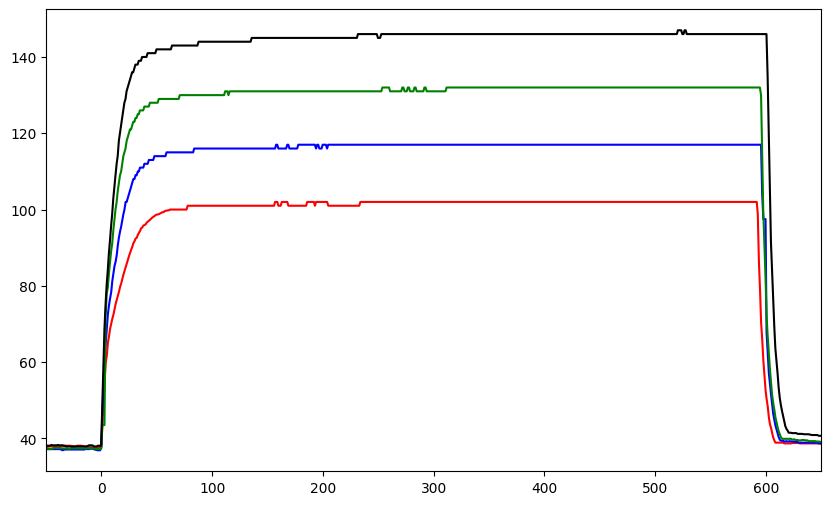

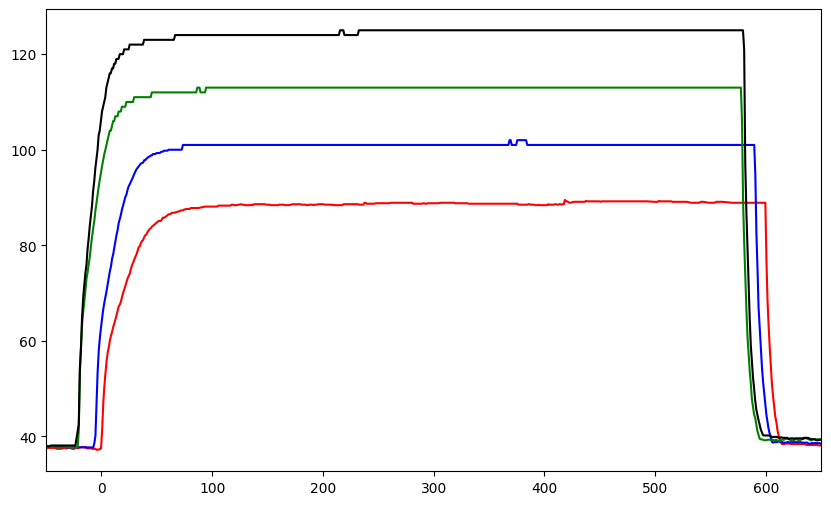

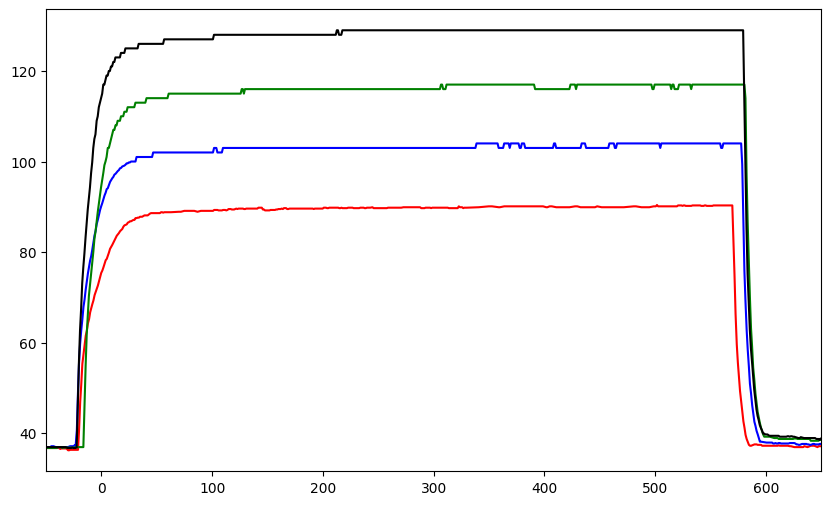

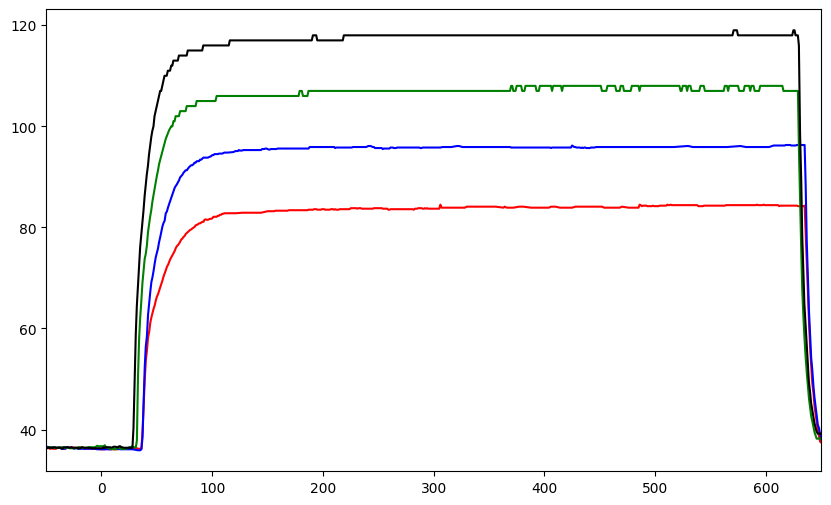

([array([-300.16726422, -299.13177514, -298.1904211 , ...,  896.85805821,
          897.79941201,  898.83490086]),
  array([-296.17049646, -295.22914267, -294.19365358, ...,  900.76069069,
          901.79617977,  902.83166885]),
  array([-298.23247504, -297.29112101, -293.24330068, ...,  893.70953751,
          894.74502659,  896.72186923]),
  array([-299.2712965 , -298.3299427 , -297.29445362, ...,  897.65989065,
          898.69537973,  899.73086882])],
 [array([37.5, 37.5, 37.4, ..., 37.7, 37.8, 37.8]),
  array([38.3, 38.1, 37.9, ..., 38.2, 38.2, 38.2]),
  array([38.1, 38.1, 37.9, ..., 38.1, 37.9, 38.1]),
  array([37.7, 37.7, 37.7, ..., 39.2, 39.2, 39.2])])

In [62]:
#function to draw heating curves
#input: a list of potentiostat paths, a list of temp_data paths (SAME ORDER), and parameters. this is the same set of inputs as the above calibrationLine function
#output: nothing, but it does draw some pretty graphs
#prerequisite functions: unstripe, readPotentiostat, jumpFind, noiseRemove, tempPeakFind (though I think that the function could be rewritten to need edgeFind rather than tempPeakFind)

def heatingCurve(potentiostat_data_list, raw_temp_datas_list, parameters, video_path_list = False, sample_wanted = 0, offsets = False,cycles_wanted = [1,2,3,4], colors = ["r","b","g","Black"]):

    #get our list of potentiostat dictionaries
    potentiostat_unstriped_list = [unstripe(potentiostat_data, parameters) for potentiostat_data in potentiostat_data_list]

    #make a list of potentiostat_time_ON lists, but with all data converted to epoch time. in the future it miht be worth just converting all the time data to epoch time as soon as it gets input to work with it more easily
    list_temp_time_ON = [[time.timestamp() for time in tempPeakFind(potentiostat_data, raw_temp_data)["potentiostat_time_ON"]] for potentiostat_data, raw_temp_data in zip(potentiostat_unstriped_list, raw_temp_datas_list)]

    noise_removed_list = [noiseRemove(raw_temp_data) for raw_temp_data in raw_temp_datas_list]
    #print("ONE\n",noise_removed_list[0][1])
    #print("ZERO\n",noise_removed_list[0][0])
    #for noise_removed in noise_removed_list:
        #print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        #print(noise_removed[1])
        #print(len(noise_removed[1]))
    
    small_temp_list = []
    small_time_list = []
    #get the filtered temperature data and seperate it into time and temperature. the time list needs to be an array for later use, the temperature list could be converted into an array but doesnt need to be
    if not video_path_list:
        temp_data_list = [noise_removed[0] for noise_removed in noise_removed_list]
        temp_time_list =[np.array(noise_removed[1]) for noise_removed in noise_removed_list]
    else:
        temp_data_list = [noiseRemove(raw_temp_data,video_path)[0] for raw_temp_data,video_path in zip(raw_temp_datas_list,video_path_list)]
        temp_time_list =[np.array(noiseRemove(raw_temp_data,video_path)[1]) for raw_temp_data,video_path in zip(raw_temp_datas_list,video_path_list)]
    
    #loop through the data, first by sample, and then by voltage hold, and plot the curves. it is currently set to plot one curve per sample, but if you want to plot all the data on one graph you can totally do that by moving the "fig,ax" = and the "plt.show()" out of the loop
    for samplenumber, sample in enumerate(list_temp_time_ON):
       # fig,ax = plt.subplots(figsize = (6,10))
        counter = 0
        inner_counter = 0
        fig,ax = plt.subplots(figsize = (10,6))
        for time in sample:
            counter+=1

            #this selects for the data within 700 seconds of the start of the voltage hold. in theory this could be 600 seconds but it doesn't take much computing power to overkill it.
            indeces = np.flatnonzero((temp_time_list[samplenumber]>time-300)&(temp_time_list[samplenumber]<time+900))
            small_temp = temp_data_list[samplenumber][indeces]
            small_time = temp_time_list[samplenumber][indeces]-time # "-time" requires the temptimelist to be an array. we need to subtract the starttimes to make them all line up neatly

            #now we plot those snippets
            if counter in cycles_wanted:
                
                try:
                    plot = ax.plot(small_time+offsets[inner_counter], small_temp, c = colors[inner_counter])

                    if samplenumber==sample_wanted:
                        small_temp_list.append(small_temp)
                        small_time_list.append(small_time+offsets[inner_counter])
                except:
                    print("NO OFFSET")
                    plot = ax.plot(small_time, small_temp, c = colors[inner_counter])

                    if samplenumber==sample_wanted:
                        small_temp_list.append(small_temp)
                        small_time_list.append(small_time)
                inner_counter +=1

        #set the bounds, the experiment takes 600s to run, so here we have selected 0 to 600, but you can do whatever. try to make the bounds fall completely within whatever the snippet size defined above is
        ax.set_xlim(left = -50, right = 650)
        plt.show()
    return small_time_list,small_temp_list

#print([calibration_potentiostat_data[3]])
#heatingCurve(calibration_potentiostat_data_high,calibration_temperature_data_high,parameters_high)
heatingCurve(calibration_potentiostat_data_low, calibration_temperature_data_low, parameters_low, offsets=[-1,3,0,0])

#heatingCurve([calibration_potentiostat_data[4]], [calibration_temperature_data[4]], parameters)
#print("4")

In [63]:
#defining the function used to calculate prediction bands
#frankly, this is a code snippet copied from the web that I cannot find right now (here is a link to a stack overflow with similar code, but I copied it from somewhere else: https://stackoverflow.com/questions/54545377/how-to-plot-data-prediction-bar-with-supblots)
#this is a functional black box, but it does seem to work

#inputs: x_data, y_data, confidence (optional default is 95%), x limits (optional again, default is 50 to 250 in which all currents tested lie)
#outputs: [the x points, the lower prediction band points, the upper prediction band points, popt (? i do not remember what this is), the optimised function, the confidence for some reason]

def predictionBands(x_data, y_data, confidence = 0.95, xlim = [50,250]):
    n = len(y_data)

    def f(x, a, b):
        return a * x + b

    popt, pcov = scipy.optimize.curve_fit(f, x_data, y_data)

    # retrieve parameter values
    a = popt[0]
    b = popt[1]
    #print('Optimal Values')
    #print('a: ' + str(a))
    #print('b: ' + str(b))

    # compute r^2
    r2 = 1.0-(sum((y_data-f(x_data,a,b))**2)/((n-1.0)*np.var(y_data,ddof=1)))
    #print('R^2: ' + str(r2))

    # calculate parameter confidence interval
    a,b = uncertainties.correlated_values(popt, pcov)
    #print('Uncertainty')
    #print('a: ' + str(a))
    #print('b: ' + str(b))
    # calculate regression confidence interval
    px = np.linspace(xlim[0], xlim[1], 40000)
    py = a*px+b
    nom = uncertainties.unumpy.nominal_values(py)
    std = uncertainties.unumpy.std_devs(py)

    def predband(x, xd, yd, p, func, conf=0.95):
        # x = requested points
        # xd = x data
        # yd = y data
        # p = parameters
        # func = function name
        alpha = 1.0 - conf    # significance
        N = xd.size          # data sample size
        var_n = len(p)  # number of parameters
        # Quantile of Student's t distribution for p=(1-alpha/2)
        q = scipy.stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
        # Stdev of an individual measurement
        se = np.sqrt(1. / (N - var_n) * \
                    np.sum((yd - func(xd, *p)) ** 2))
        # Auxiliary definitions
        sx = (x - xd.mean()) ** 2
        sxd = np.sum((xd - xd.mean()) ** 2)
        # Predicted values (best-fit model)
        yp = func(x, *p)
        # Prediction band
        dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
        # Upper & lower prediction bands.
        lpb, upb = yp - dy, yp + dy
        return lpb, upb

    lpb, upb = predband(px, x_data, y_data, popt, f, confidence)
    return [px,lpb,upb,nom-1.96*std, nom+1.96*std]

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


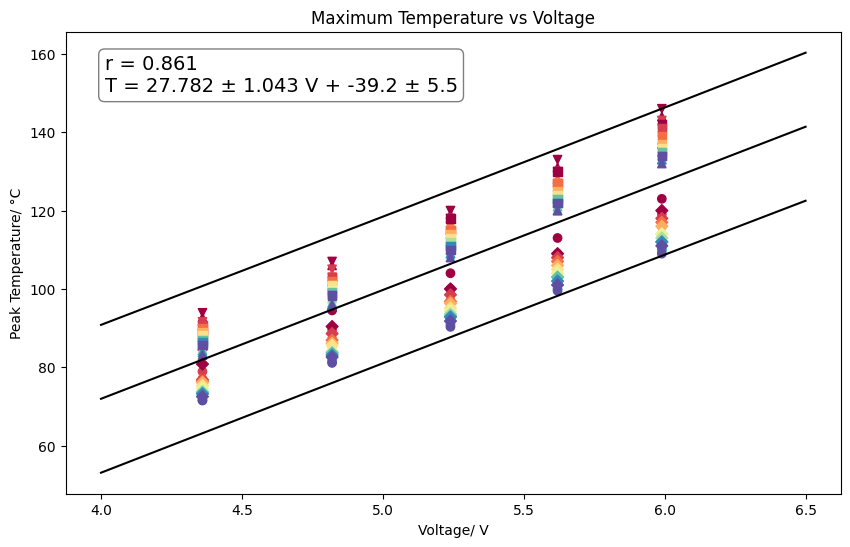

LinregressResult(slope=0.9420611998931623, intercept=-6.700189206536606, rvalue=0.9784299132326675, pvalue=7.162538561791501e-172, stderr=0.012630188605542153, intercept_stderr=1.5231492674256302)


findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


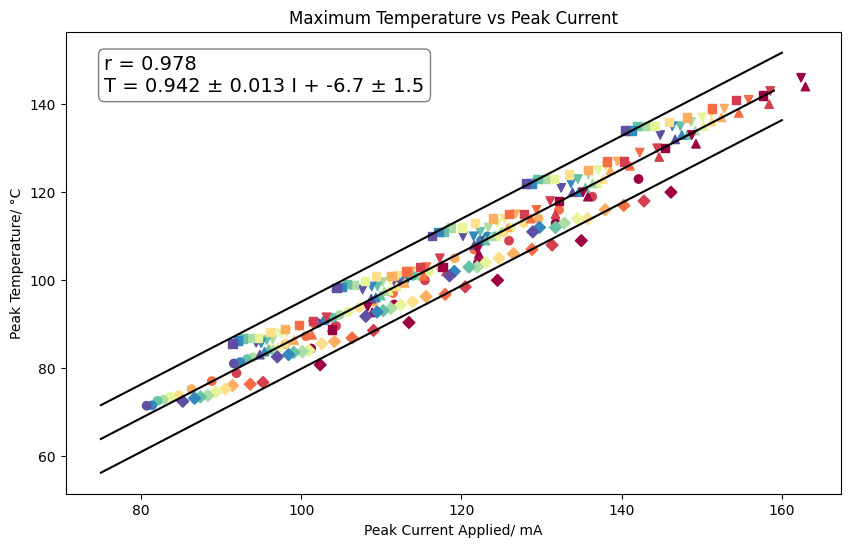

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


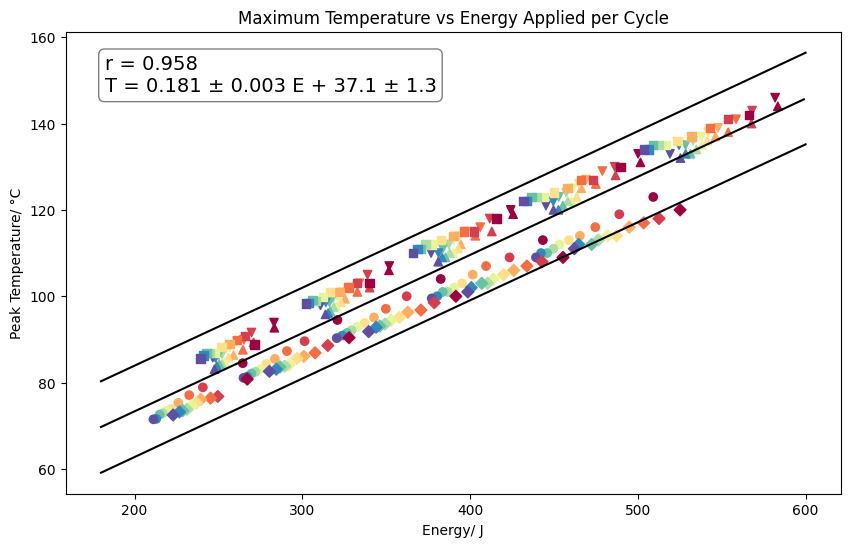

[range(180, 600),
 [69.7207057737663,
  69.90182183667685,
  70.08293789958738,
  70.26405396249793,
  70.44517002540846,
  70.626286088319,
  70.80740215122955,
  70.9885182141401,
  71.16963427705065,
  71.35075033996118,
  71.53186640287173,
  71.71298246578226,
  71.89409852869281,
  72.07521459160336,
  72.2563306545139,
  72.43744671742445,
  72.618562780335,
  72.79967884324553,
  72.98079490615606,
  73.16191096906661,
  73.34302703197716,
  73.5241430948877,
  73.70525915779825,
  73.8863752207088,
  74.06749128361933,
  74.24860734652987,
  74.42972340944041,
  74.61083947235096,
  74.79195553526151,
  74.97307159817206,
  75.1541876610826,
  75.33530372399314,
  75.51641978690368,
  75.69753584981422,
  75.87865191272476,
  76.05976797563531,
  76.24088403854586,
  76.4220001014564,
  76.60311616436694,
  76.78423222727749,
  76.96534829018802,
  77.14646435309857,
  77.32758041600911,
  77.50869647891966,
  77.68981254183021,
  77.87092860474074,
  78.05204466765129,
  78.2

In [65]:
#the function to draw the various calibration lines, this one is long
#inputs: list of potentiostat lists, list of temperature data paths, parameters (including "repeats", "per_repeat", as well as "graph_path" and "folder_name", where the graphs will be stored), and colors, which is pretty self explanatory and has a very pretty default.
# these inputs are very similar to the inputs required for calibrationLine... I wonder why...
#outputs: nothing, but draws and saves some very pretty graphs
#prerequisites: calibrationLine, unstripe, readPotentiostat, jumpFind, tempPeakFind, noiseRemove, peakCurrent, findEnergy, predictionBands (wow that's a lot! (but even more this time!))

def calibrationLineDraw(potentiostat_path_lists, temp_path_list, parameters, colors = ["#9e0142","#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]):
    
    #despite having run calibrationLine previously specifically to avoid rerunning it, here we rerun it. think of it as a code-mandated one minute stretch time.
    #this is where we get all our data, with the array structure allowing us to selectively use it easily
    calibration_dictionary = calibrationLine(potentiostat_path_lists, temp_path_list, parameters)

    #here we define a list of shapes for the markers to be, allowing us to distinguish by sample. if you have more than 5 samples you want to plot, you must add to the list
    shapes = ["o", "^", "v", "s", "D"]

    #defining the location in which we will save the graphs
    save_path = os.path.join(parameters["graph_path"], parameters["folder_name"])
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    #here we draw the temperature vs voltage graph
    #listen up here because most of the code is shared between the graphs and I don't want to comment them all
    fig,ax = plt.subplots(figsize = (10,6))
   
    #setting axis and plot titles, simple
    ax.set_title("Maximum Temperature vs Voltage")
    ax.set_xlabel("Voltage/ V")
    ax.set_ylabel("Peak Temperature/ °C")
    
    #making a textbox in which we will place the formula for the line of best fit, as well as the uncertainty in the slope and intercept. it is seriffed to look different from the axis text.
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("r = " + str(round(calibration_dictionary["voltage_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_dictionary["voltage_regression"].slope,3)) + " ± " + str(round(calibration_dictionary["voltage_regression"].stderr,3)) + " V + " + str(round(calibration_dictionary["voltage_regression"].intercept,1)) +" ± " + str(round(calibration_dictionary["voltage_regression"].intercept_stderr,1))
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")
    
    #making points for the line of best fit, and plotting it
    fit_line_x = np.arange(4, 7, 0.5)
    fit_line_y = [calibration_dictionary["voltage_regression"].slope * x + calibration_dictionary["voltage_regression"].intercept for x in fit_line_x]
    ax.plot(fit_line_x,fit_line_y, c = "black")

    #finding the prediction bands, and plotting them
    upper_bound_y = predictionBands(calibration_dictionary["voltage_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [4,6.5])[2]
    lower_bound_y = predictionBands(calibration_dictionary["voltage_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [4,6.5])[1]
    bounds_x = predictionBands(calibration_dictionary["voltage_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [4,6.5])[0]
    ax.plot(bounds_x,lower_bound_y, c = "black")
    ax.plot(bounds_x,upper_bound_y, c = "black") 

    #looping through all the samples and plotting points with colors representing different repeats and shapes representing different samples.
    for x in range(len(calibration_dictionary["temperature_array"])):
        ax.scatter(calibration_dictionary["voltage_array"][x].flatten(), calibration_dictionary["temperature_array"][x].flatten(), c = colors*int(len(calibration_dictionary["voltage_array"][x].flatten())/(len(colors))), marker = shapes[x])

    #save and show the figure
    voltage_path = os.path.join(save_path,"Voltage Calibration Graph.png")
    plt.savefig(voltage_path)
    plt.show()

    #imagine i wrote the same comments for these two almost identical plotting functions
    fig,ax = plt.subplots(figsize = (10,6))
   
    ax.set_title("Maximum Temperature vs Peak Current")

    ax.set_xlabel("Peak Current Applied/ mA")
    ax.set_ylabel("Peak Temperature/ °C")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    print(calibration_dictionary["current_regression"])
    box_text = ("r = " + str(round(calibration_dictionary["current_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_dictionary["current_regression"].slope,3)) + " ± " + str(round(calibration_dictionary["current_regression"].stderr,3)) + " I + " + str(round(calibration_dictionary["current_regression"].intercept,1)) +" ± " + str(round(calibration_dictionary["current_regression"].intercept_stderr,1))
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")

    fit_line_x = range(75, 160, 1)
    fit_line_y = [calibration_dictionary["current_regression"].slope * x + calibration_dictionary["current_regression"].intercept for x in fit_line_x]
    ax.plot(fit_line_x,fit_line_y, c = "black")

    upper_bound_y = predictionBands(calibration_dictionary["current_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [75,160])[2]
    lower_bound_y = predictionBands(calibration_dictionary["current_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [75,160])[1]
    bounds_x = predictionBands(calibration_dictionary["current_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [75,160])[0]
    ax.plot(bounds_x,lower_bound_y, c = "black")
    ax.plot(bounds_x,upper_bound_y, c = "black")    
    for x in range(len(calibration_dictionary["temperature_array"])):
        ax.scatter(calibration_dictionary["current_array"][x].flatten(), calibration_dictionary["temperature_array"][x].flatten(), c = colors*int(len(calibration_dictionary["current_array"][x].flatten())/len(colors)), marker = shapes[x])

    current_path = os.path.join(save_path,"Current Calibration Graph.png")

    plt.savefig(current_path)
    plt.show()


    fig,ax = plt.subplots(figsize = (10,6))

    ax.set_title("Maximum Temperature vs Energy Applied per Cycle")

    ax.set_xlabel("Energy/ J")
    ax.set_ylabel("Peak Temperature/ °C")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("r = " + str(round(calibration_dictionary["energy_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_dictionary["energy_regression"].slope,3)) + " ± " + str(round(calibration_dictionary["energy_regression"].stderr,3)) + " E + " + str(round(calibration_dictionary["energy_regression"].intercept,1)) +" ± " + str(round(calibration_dictionary["energy_regression"].intercept_stderr,1))
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")

    fit_line_x = range(180, 600, 1)
    fit_line_y = [calibration_dictionary["energy_regression"].slope * x + calibration_dictionary["energy_regression"].intercept for x in fit_line_x]
    ax.plot(fit_line_x,fit_line_y, c = "black")

    upper_bound_y = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600])[2]
    lower_bound_y = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600])[1]
    bounds_x = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600] )[0]
    ax.plot(bounds_x,lower_bound_y, c = "black")
    ax.plot(bounds_x,upper_bound_y, c = "black")  
    for x in range(len(calibration_dictionary["temperature_array"])):
        ax.scatter(calibration_dictionary["energy_array"][x].flatten(), calibration_dictionary["temperature_array"][x].flatten(), c = colors*int(len(calibration_dictionary["energy_array"][x].flatten())/len(colors)), marker = shapes[x])

    energy_path = os.path.join(save_path,"Energy Calibration Graph.png")

    plt.savefig(energy_path)
    plt.show()
    return [fit_line_x, fit_line_y, upper_bound_y, lower_bound_y, bounds_x, calibration_dictionary]

#i don't much like the default serif font, lets make it a better one
plt.rcParams["font.family"] = "Sans Serif"
plt.rcParams["font.serif"] = "Palatino Linotype"
parameters = {"repeats" : 10, "per_repeat" : 5, "graph_path" : r"/media/kp556/thlirth/Summer Project/graphs", "folder_name" : "calibration graphs low"}
calibrationLineDraw(calibration_potentiostat_data_high,calibration_temperature_data_high,parameters)#, colors= ["#ff0090","#9e0142","#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#AC8ED9"])    
    

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


[[84.92180395750484, 96.22120297738016, 108.1539481709537, 120.09249789850996, 82.89341578318079, 94.5186404180073, 106.32305702790518, 118.18231123846459, 81.9720334630338, 93.41182451721608, 105.05212413784967, 116.92754849625354, 81.36556276117551, 92.67211370395052, 104.22692452932932, 115.91511645201066, 80.79334642103356, 91.99994939895747, 103.44487028121185, 115.01209955721772, 80.32797373075158, 91.46148605149463, 102.82232050697597, 114.38858889266257, 79.97239644965617, 90.98876369271386, 102.26697511293322, 113.70298078904744, 79.60700107558712, 90.54899085093096, 101.73299908961997, 113.14745042346, 79.3092362731056, 90.14952085806068, 101.2724242560623, 112.52555690550288, 78.99455633591856, 89.74970790700206, 100.78595391519929, 112.0015400153889, 78.677624316102, 89.38570503307454, 100.3780472855764, 111.56481813606925, 78.40702237326548, 89.04897344594882, 100.0227887896875, 111.12871779245161], [79.66994100196209, 89.229333075891, 99.53095984627815, 109.04196394568602

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


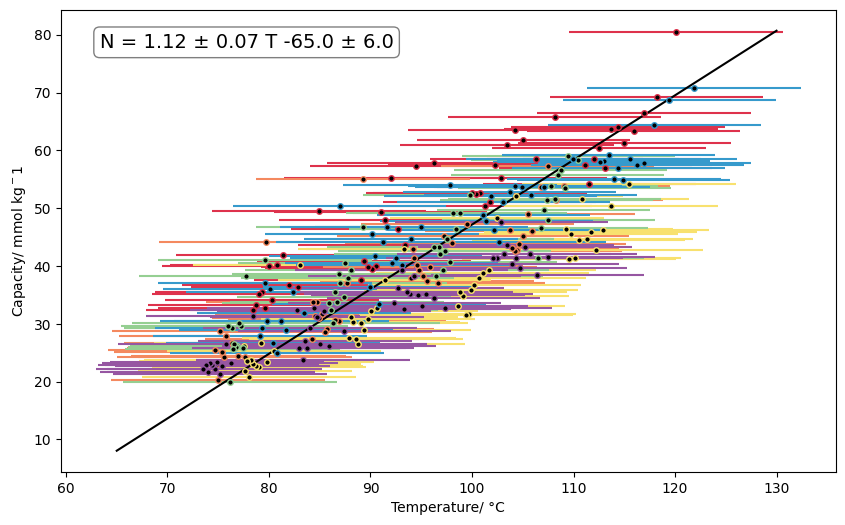

In [67]:
#defining the function used for data analysis of the cycling experiment
#inputs: a list of potentiostat paths, a path to an aranet file, parameters (including "repeats", "rest_time", and "mass", which should be an array of masses of the samples used in the same order as the potentiostat paths)
#outputs: something to do with the fit and the covarience of the fit? i don't remember writing that. but also a pretty graph
#prerequisites: edgePeakFind, unstripe, readAranet, readPotentiostat, jumpFind, predictionBands, as well as calibrationLine having ALREADY been run at some point to generate the calibration data

def analysisCycling(potentiostat_path_lists,aranet_file,calibration_data, parameters,colors = ["#de324c", "#f4895f", "#f8e16f", "#95cf92", "#369acc", "#9656a2"]):
    

    output_dictionary ={}

    #create a list of dictionaries of edges found and CO2 data, with one dictionary per sample    
    peaks_lists = [edgePeakFind(potentiostat_path_list,aranet_file, parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of the chronologically corrected potentiostat data dictionaries, with one dictionary per sample
    potentiostat_unstriped_list = [unstripe(potentiostat_path_list,parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of lists of peak currents, one list per sample (with the sublist being one data point per voltage hold)
    current_peak_lists = [peakCurrent(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #create a list of lists of energies per cycle, again one list per cycle (sublists are one datapoint per voltage hold) #
    #this isn't in use as of yet but doesn't slow down the programme very much and could be useful later, feel free to comment it out or remove it entirely
    energy_lists = [findEnergy(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #using the dictionaries created by peaksFound, find a capacity for each voltage hold. this is dependent on the mass as well. once again, one list per sample, one datapoint per hold
    capacity_lists = [[swing_CO2/mass for swing_CO2 in peaks_found["swingCO2"]] for peaks_found,mass in zip(peaks_lists,parameters["mass"])]

    #you must be getting bored of this by now. now using the peak current and the calibration graph to estimate the temperature for each voltage hold. data structured identically
    #it turns out energy is a better fit, we will comment this out for future use
    #temperature_lists = [[current * calibration_data["current_regression"].slope + calibration_data["current_regression"].intercept for current in current_peak_list] for current_peak_list in current_peak_lists]
    temperature_lists = [[energy * calibration_data["energy_regression"].slope + calibration_data["energy_regression"].intercept for energy in energy_list] for energy_list in energy_lists]

    #something different! now we use the predictionBands formula to calculate the error in the temperature
    #energy still a better fit, still commenting out the current fit
    #temp_bands = predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())
    
    temp_bands = predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])

    #as predictionBands outputs a list of points, this is a tad inelegant. we want to correlate each current to a top and bottom temperature, and to do that we need to make sure the current is in the list
    #we do this by rounding the current and the prediction bands as well to two significant figures (rounding error is negligeable) and making sure the predictionBand covers all possible points under that constraint 
    #and again
    #rounded_band_current = [round(x, 2) for x in predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())[0]]
    rounded_band_energy = [round(x, 2) for x in predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])[0]]

    #using those rounded currents, we find the bandwidth at that point and use that as the error. one list per sample, one point per hold, again 
    temperature_error_lists = [[(temp_bands[2][rounded_band_energy.index(round(energy,2))] - temp_bands[1][rounded_band_energy.index(round(energy,2))])/2 for energy in energy_list] for energy_list in energy_lists]

    #plotting!
    fig,ax = plt.subplots(figsize = (10,6))

    #looping through the samples
    for sample in range(len(temperature_lists)):
        #unremarkable, save for the *1000000000, which converts the units from mol/mg to mmol/kg
        ax.errorbar(temperature_lists[sample], [capacity_mol_mg *1000000000 for capacity_mol_mg in capacity_lists[sample]], c = colors[sample], xerr= temperature_error_lists[sample], linestyle = "None", marker = "o", mfc = "black", mec = colors[sample], ms = 4 )


    #line of best fit time! wooo
    #now, scipy.optimise has what we want be we have to wrangle it annoyingly
    
    def f(y,m,b):
        return ((y-b)/m)
    
    print(temperature_lists)
    for x in temperature_lists:
        print(type(x))
    print(sum(temperature_lists, []))
    
    #we must get the "x data" and "y data" the WRONG way round here because it expects an uncertainty in y, but we have an uncertainty in x
    fit,cov_fit = scipy.optimize.curve_fit(f, [capacity_mol_mg*1000000000 for capacity_mol_mg in sum(capacity_lists, [])], sum(temperature_lists, []), sigma = sum(temperature_error_lists, []), absolute_sigma = True)
    fit_err = np.sqrt(np.diag(cov_fit))

    px = np.linspace(65, 130, 20000)
    py = [fit[0]*x+fit[1] for x in px]

    ax.plot(px,py, c = "black")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("N = " + str(round(fit[0],2)) + " ± " + str(round(fit_err[0],2)) + " T " + str(round(fit[1],0)) + " ± " + str(round(fit_err[1],0)))
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")

    ax.set_xlabel("Temperature/ °C")
    ax.set_ylabel("Capacity/ mmol kg$^-1$")
    #ax.set_title("Cycling Capacity by Approximate Temperature")
    #ax.set_ylim(bottom=40,top=120)

    plt.show()
    return(fit,cov_fit)
#print(pandas.read_csv(r"/media/kp556/thlirth/Summer Project/Sample 4.6\2024-08-19 CO2 Sample 4.6 _02_CstV_C04.txt",usecols=[0,1,2,3], sep = '\t',header=0))
test_potentiostat_data_high = [[r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _05_WAIT_C04.txt"],  
                          
                        [r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _05_WAIT_C04.txt"]]


test_aranet_data_high = r"/media/kp556/thlirth/GitHub/Aranet4_11EF7_2024-09-06T15_52_510100.csv"

test_potentiostat_data_low = [[r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _06_WAIT_C04.txt"],
                         
                        [r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _06_WAIT_C04.txt"]]

test_aranet_data_low = r"/home/kp556/Downloads/Aranet4_11EF7_2024-09-16T16_18_390100.csv"

test_params_high = {"repeats" : 12, "per_repeat" : 4, "graph_path" : r"/media/kp556/thlirth/Summer Project/", "folder_name" : "calibration graphs high", "mass" : [47.1,47.9,45.9,45.5,46.5,48.5] , "rest_time" : 5}
test_params_low = {"repeats" : 12, "per_repeat" : 4, "graph_path" : r"/media/kp556/thlirth/Summer Project/", "folder_name" : "calibration graphs low", "mass" : [53.8,54.6,52.3,50.7,51.9] , "rest_time" : 5}


fit = analysisCycling(test_potentiostat_data_high,test_aranet_data_high,calibration_data_high,test_params_high)
#fit_test1 = analysisCycling([test_potentiostat_data_low[0]],test_aranet_data_low,calibration_data_low,test_params_low,colors=["#de324c"])
#fit_test2 = analysisCycling([test_potentiostat_data_low[1]],test_aranet_data_low,calibration_data_low,test_params_low,colors=["#f4895f"])
#fit_test3 = analysisCycling([test_potentiostat_data_low[2]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#f8e16f"])
#fit_test4 = analysisCycling([test_potentiostat_data_low[3]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#95cf92"])
#fit_test5 = analysisCycling([test_potentiostat_data_low[4]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#369acc"])

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


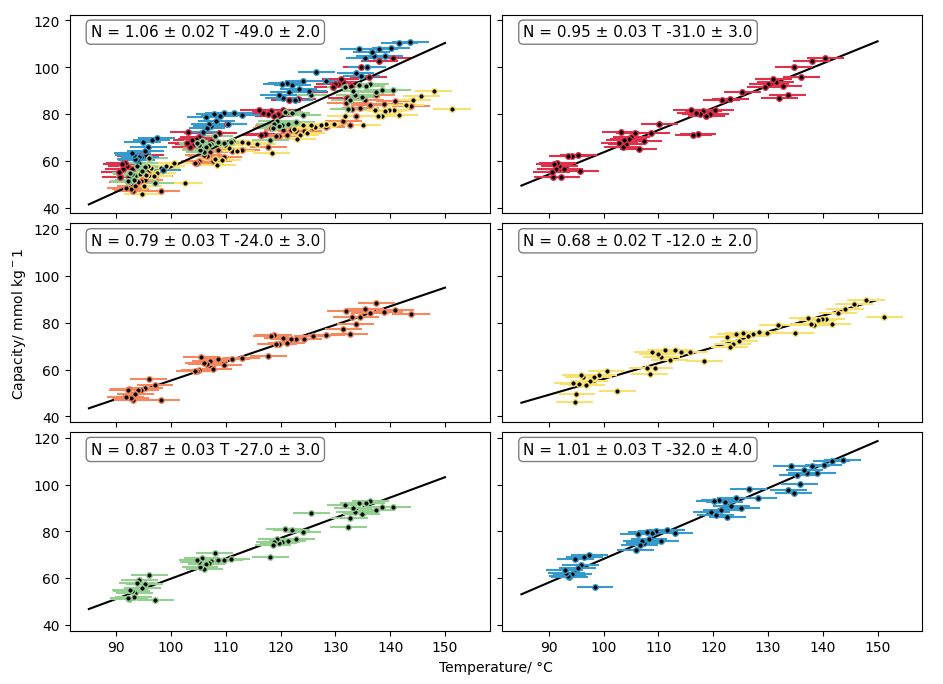

In [73]:
#hacking the multigraph
def analysisCycling(potentiostat_path_lists,aranet_file,calibration_data, parameters,colors = ["#de324c", "#f4895f", "#f8e16f", "#95cf92", "#369acc", "#9656a2"]):
    

    output_dictionary ={}

    #create a list of dictionaries of edges found and CO2 data, with one dictionary per sample    
    peaks_lists = [edgePeakFind(potentiostat_path_list,aranet_file, parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of the chronologically corrected potentiostat data dictionaries, with one dictionary per sample
    potentiostat_unstriped_list = [unstripe(potentiostat_path_list,parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of lists of peak currents, one list per sample (with the sublist being one data point per voltage hold)
    current_peak_lists = [peakCurrent(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #create a list of lists of energies per cycle, again one list per cycle (sublists are one datapoint per voltage hold) #
    #this isn't in use as of yet but doesn't slow down the programme very much and could be useful later, feel free to comment it out or remove it entirely
    energy_lists = [findEnergy(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #using the dictionaries created by peaksFound, find a capacity for each voltage hold. this is dependent on the mass as well. once again, one list per sample, one datapoint per hold
    capacity_lists = [[swing_CO2/mass for swing_CO2 in peaks_found["swingCO2"]] for peaks_found,mass in zip(peaks_lists,parameters["mass"])]

    #you must be getting bored of this by now. now using the peak current and the calibration graph to estimate the temperature for each voltage hold. data structured identically
    #it turns out energy is a better fit, we will comment this out for future use
    #temperature_lists = [[current * calibration_data["current_regression"].slope + calibration_data["current_regression"].intercept for current in current_peak_list] for current_peak_list in current_peak_lists]
    temperature_lists = [[energy * calibration_data["energy_regression"].slope + calibration_data["energy_regression"].intercept for energy in energy_list] for energy_list in energy_lists]

    #something different! now we use the predictionBands formula to calculate the error in the temperature
    #energy still a better fit, still commenting out the current fit
    #temp_bands = predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())
    
    temp_bands = predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])

    #as predictionBands outputs a list of points, this is a tad inelegant. we want to correlate each current to a top and bottom temperature, and to do that we need to make sure the current is in the list
    #we do this by rounding the current and the prediction bands as well to two significant figures (rounding error is negligeable) and making sure the predictionBand covers all possible points under that constraint 
    #and again
    #rounded_band_current = [round(x, 2) for x in predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())[0]]
    rounded_band_energy = [round(x, 2) for x in predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])[0]]

    #using those rounded currents, we find the bandwidth at that point and use that as the error. one list per sample, one point per hold, again 
    temperature_error_lists = [[(temp_bands[2][rounded_band_energy.index(round(energy,2))] - temp_bands[1][rounded_band_energy.index(round(energy,2))])/2 for energy in energy_list] for energy_list in energy_lists]

    


    #line of best fit time! wooo
    #now, scipy.optimise has what we want be we have to wrangle it annoyingly
    
    def f(y,m,b):
        return ((y-b)/m)
    
    #plotting!
    fig,ax = plt.subplots(3,2,sharex=True, sharey = True,figsize = (11,8))

    for sample in range(len(temperature_lists)):
        ax[0,0].errorbar(temperature_lists[sample], [capacity_mol_mg *1000000000 for capacity_mol_mg in capacity_lists[sample]], c = colors[sample], xerr= temperature_error_lists[sample], linestyle = "None", marker = "o", mfc = "black", mec = colors[sample], ms = 4 )
    fit,cov_fit = scipy.optimize.curve_fit(f, [capacity_mol_mg*1000000000 for capacity_mol_mg in sum(capacity_lists, [])], sum(temperature_lists, []), sigma = sum(temperature_error_lists, []), absolute_sigma = True)
    fit_err = np.sqrt(np.diag(cov_fit))

    px = np.linspace(85, 150, 20000)
    py = [fit[0]*x+fit[1] for x in px]

    ax[0,0].plot(px,py, c = "black")
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("N = " + str(round(fit[0],2)) + " ± " + str(round(fit_err[0],2)) + " T " + str(round(fit[1],0)) + " ± " + str(round(fit_err[1],0)))
    ax[0,0].text(0.05, 0.95, box_text, transform=ax[0,0].transAxes, fontsize=11, verticalalignment='top', bbox=props, family = "Serif")

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.subplots_adjust(wspace=0.03, hspace=0.05)
    plt.xlabel("Temperature/ °C")
    plt.ylabel("Capacity/ mmol kg$^-1$")
    plt.ylim(bottom = 40, top = 130)
    ax[0,0].label_outer()    
    #looping through the samples
    for sample in range(len(temperature_lists)):
        vertical = int((sample+1)/2)
        horizontal = (sample+1)%2
        fit,cov_fit = scipy.optimize.curve_fit(f, [capacity_mol_mg*1000000000 for capacity_mol_mg in sum([capacity_lists[sample]], [])], sum([temperature_lists[sample]], []), sigma = sum([temperature_error_lists[sample]], []), absolute_sigma = True)
        fit_err = np.sqrt(np.diag(cov_fit))
        px = np.linspace(85, 150, 20000)
        py = [fit[0]*x+fit[1] for x in px]

        ax[vertical,horizontal].plot(px,py, c = "black")

        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        box_text = ("N = " + str(round(fit[0],2)) + " ± " + str(round(fit_err[0],2)) + " T " + str(round(fit[1],0)) + " ± " + str(round(fit_err[1],0)))
        ax[vertical,horizontal].text(0.05, 0.95, box_text, transform=ax[vertical,horizontal].transAxes, fontsize=11, verticalalignment='top', bbox=props, family = "Serif")

        #if vertical != 1:
        #    ax[vertical, horizontal].set_xticks([])
        #else:
        #    ax[vertical,horizontal].set_xticks([90,100,110],["wahoo","yipee", "the world is ending"])

        ax[vertical,horizontal].label_outer()    
        #ax[vertical,horizontal].set_ylabel("Capacity/ mmol kg$^-1$")
        #ax[vertical,horizontal].set_ylim(bottom = 40, top = 130)
        #unremarkable, save for the *1000000000, which converts the units from mol/mg to mmol/kg
        ax[vertical,horizontal].errorbar(temperature_lists[sample], [capacity_mol_mg *1000000000 for capacity_mol_mg in capacity_lists[sample]], c = colors[sample], xerr= temperature_error_lists[sample], linestyle = "None", marker = "o", mfc = "black", mec = colors[sample], ms = 4 )
    
    #print(temperature_lists)
    #for x in temperature_lists:
        #print(type(x))
    #print(sum(temperature_lists, []))
    
    #we must get the "x data" and "y data" the WRONG way round here because it expects an uncertainty in y, but we have an uncertainty in x
    
    #ax.set_title("Cycling Capacity by Approximate Temperature")
    #ax.set_ylim(bottom=40,top=120)

    plt.show()
    return(fit,cov_fit)
#print(pandas.read_csv(r"/media/kp556/thlirth/Summer Project/Sample 4.6\2024-08-19 CO2 Sample 4.6 _02_CstV_C04.txt",usecols=[0,1,2,3], sep = '\t',header=0))
test_potentiostat_data_high = [[r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.6/2024-08-19 CO2 Sample 4.6 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.5/2024-08-20 CO2 Sample 4.5 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.4/2024-08-23 CO2 Sample 4.4 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.3/2024-08-21 CO2 Sample 4.3 _05_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 4.2/2024-08-22 CO2 Sample 4.2 _05_WAIT_C04.txt"],  
                          
                        [r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _01_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 3.2/2024-08-14 CO2 Sample 3.2 _05_WAIT_C04.txt"]]


test_aranet_data_high = r"/media/kp556/thlirth/GitHub/Aranet4_11EF7_2024-09-06T15_52_510100.csv"

test_potentiostat_data_low = [[r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.1/2024-09-02 Sample 6.1 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.2/2024-09-05 Sample 6.2 _06_WAIT_C04.txt"],
                         
                        [r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.3/2024-09-06 Sample 6.3 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.4/2024-09-04 Sample 6.4 _06_WAIT_C04.txt"],

                        [r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _02_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _03_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _04_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _05_CstV_C04.txt",
                        r"/media/kp556/thlirth/Summer Project/Sample 6.5/2024-09-03 Sample 6.5 _06_WAIT_C04.txt"]]

test_aranet_data_low = r"/home/kp556/Downloads/Aranet4_11EF7_2024-09-16T16_18_390100.csv"

test_params_high = {"repeats" : 12, "per_repeat" : 4, "graph_path" : r"/media/kp556/thlirth/Summer Project/", "folder_name" : "calibration graphs high", "mass" : [47.1,47.9,45.9,45.5,46.5,48.5] , "rest_time" : 5}
test_params_low = {"repeats" : 12, "per_repeat" : 4, "graph_path" : r"/media/kp556/thlirth/Summer Project/", "folder_name" : "calibration graphs low", "mass" : [53.8,54.6,52.3,50.7,51.9] , "rest_time" : 5}


fit = analysisCycling(test_potentiostat_data_low,test_aranet_data_low,calibration_data_low,test_params_low)
#fit_test1 = analysisCycling([test_potentiostat_data_low[0]],test_aranet_data_low,calibration_data_low,test_params_low,colors=["#de324c"])
#fit_test2 = analysisCycling([test_potentiostat_data_low[1]],test_aranet_data_low,calibration_data_low,test_params_low,colors=["#f4895f"])
#fit_test3 = analysisCycling([test_potentiostat_data_low[2]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#f8e16f"])
#fit_test4 = analysisCycling([test_potentiostat_data_low[3]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#95cf92"])
#fit_test5 = analysisCycling([test_potentiostat_data_low[4]],test_aranet_data_low,calibration_data_low,test_params_low,colors = ["#369acc"])


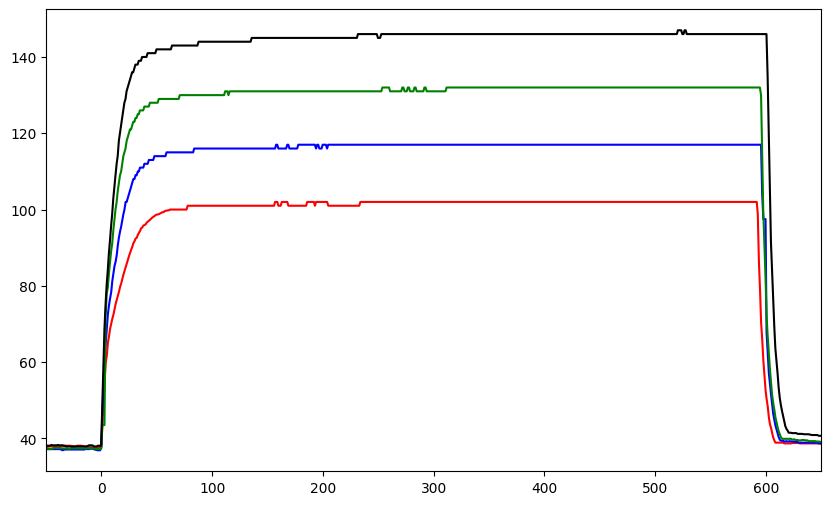

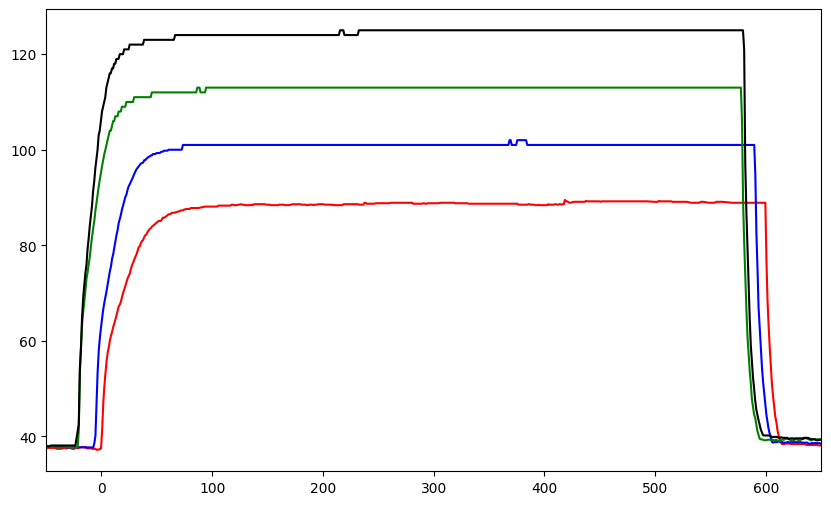

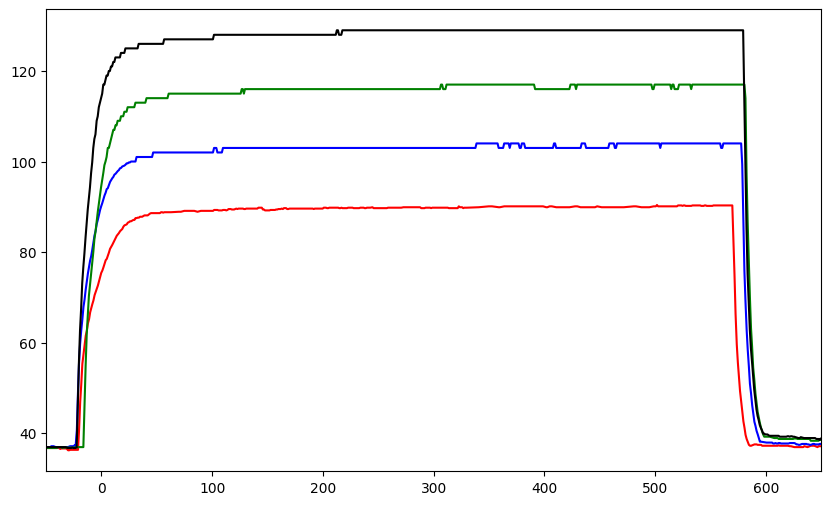

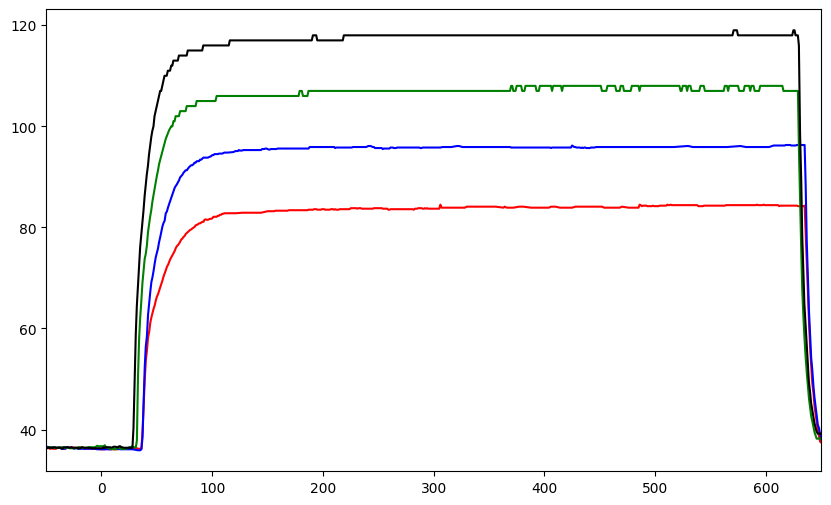

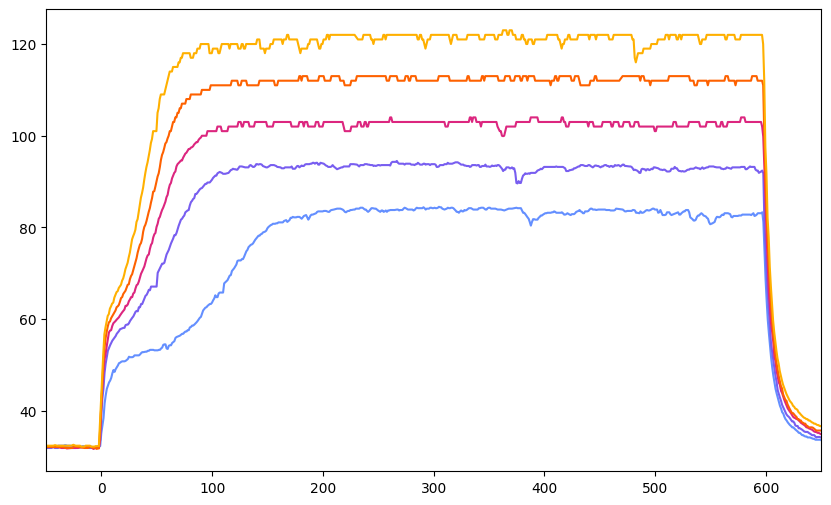

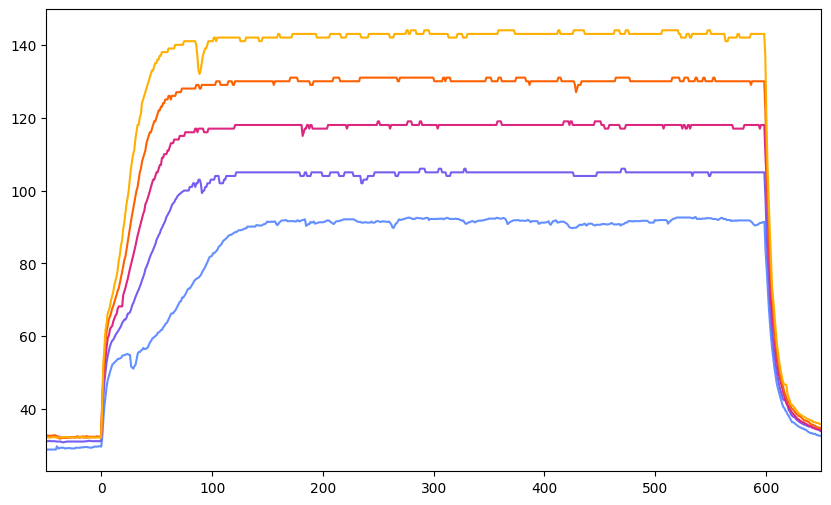

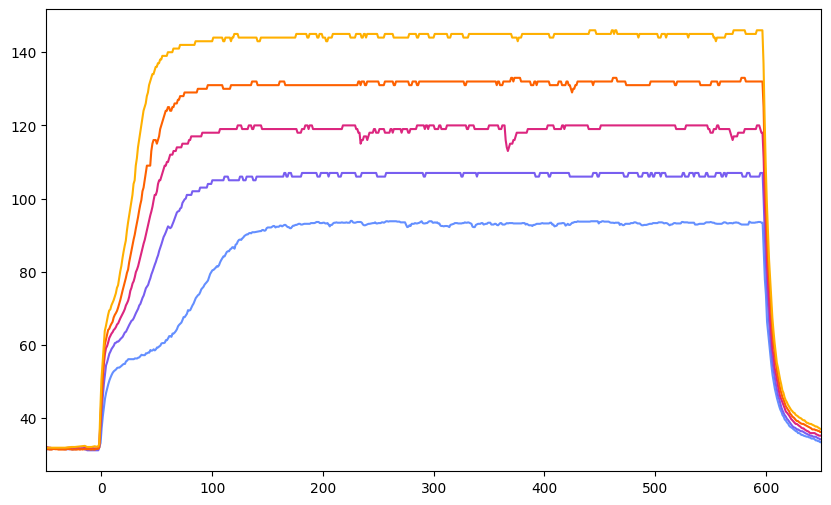

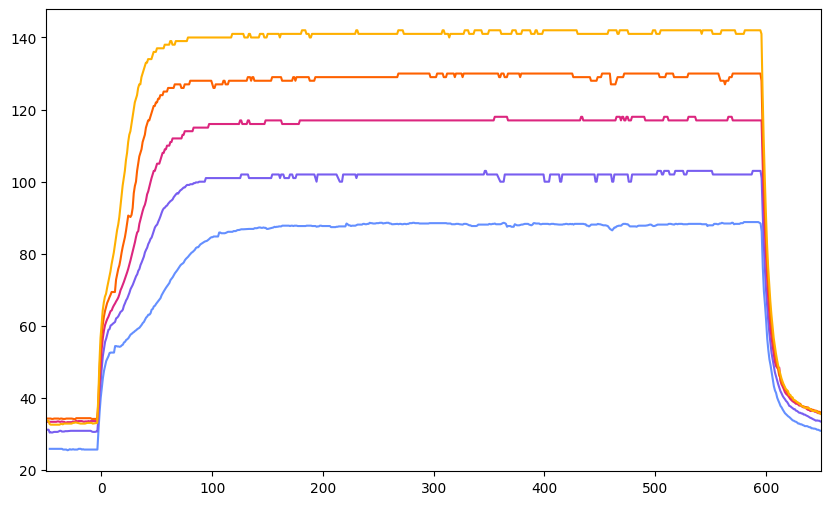

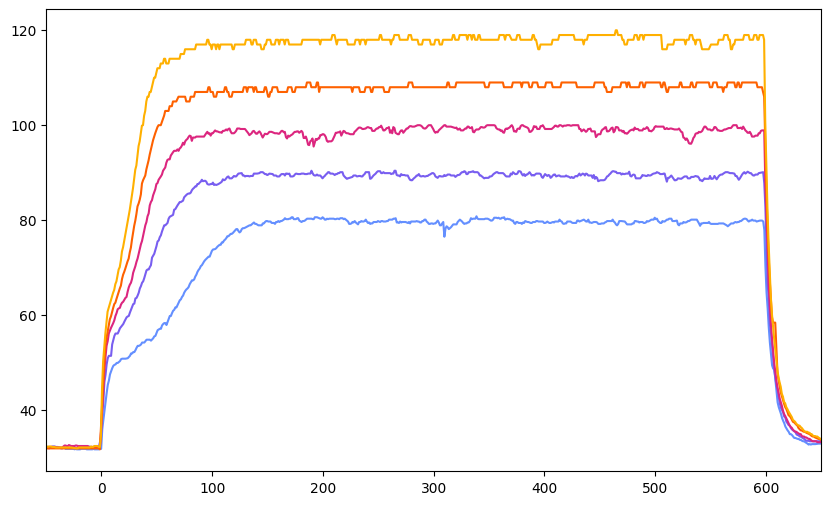

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


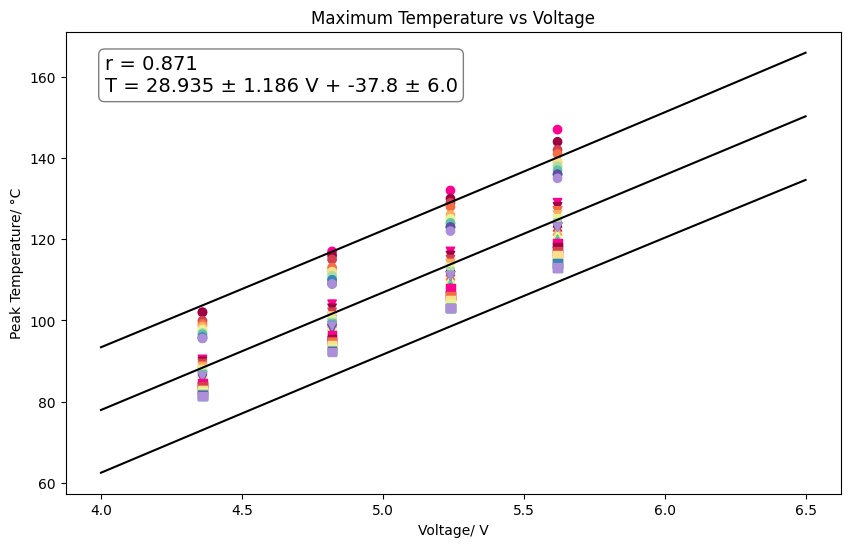

LinregressResult(slope=0.7925248273583283, intercept=16.03697582256561, rvalue=0.9702149470377185, pvalue=6.076054367429585e-119, stderr=0.014355691199308865, intercept_stderr=1.6732508936203625)


findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


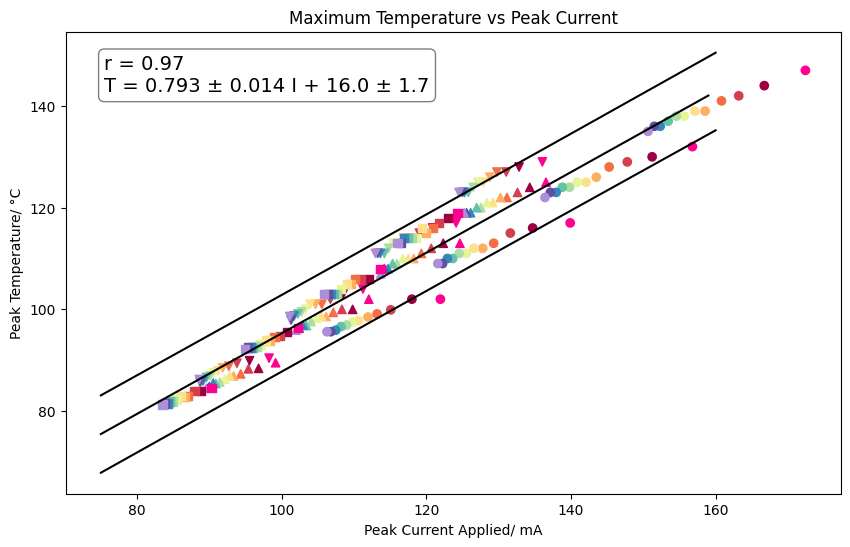

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


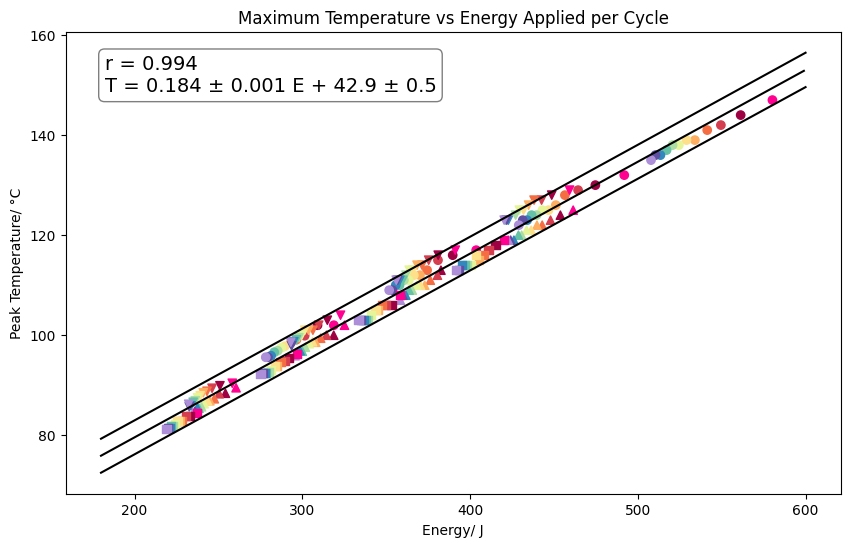

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


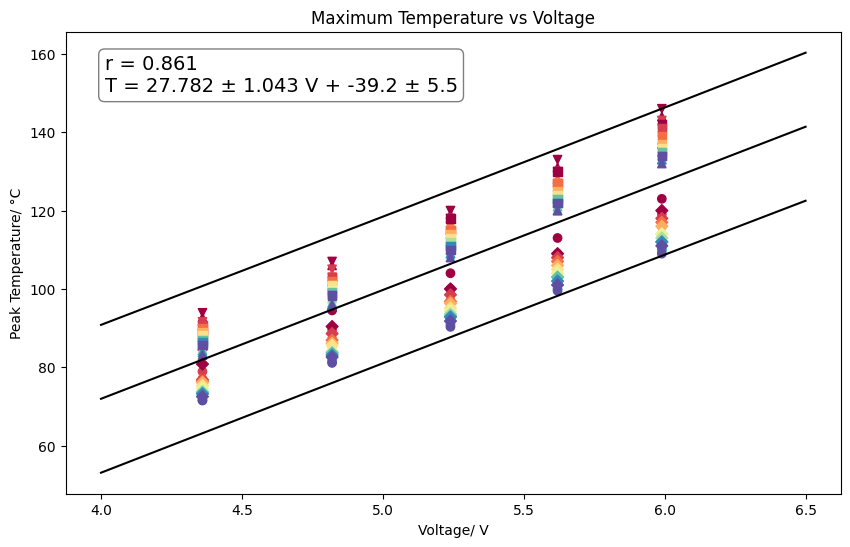

LinregressResult(slope=0.9420611998931623, intercept=-6.700189206536606, rvalue=0.9784299132326675, pvalue=7.162538561791501e-172, stderr=0.012630188605542153, intercept_stderr=1.5231492674256302)


findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


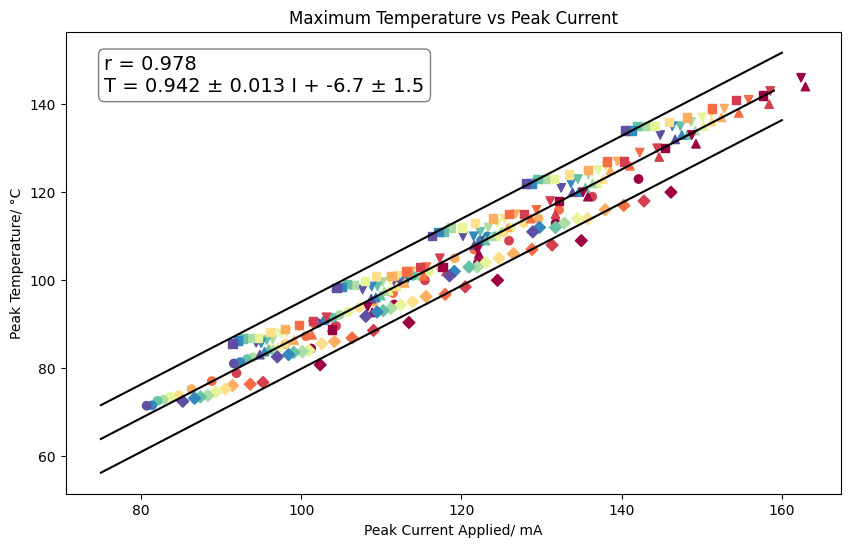

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


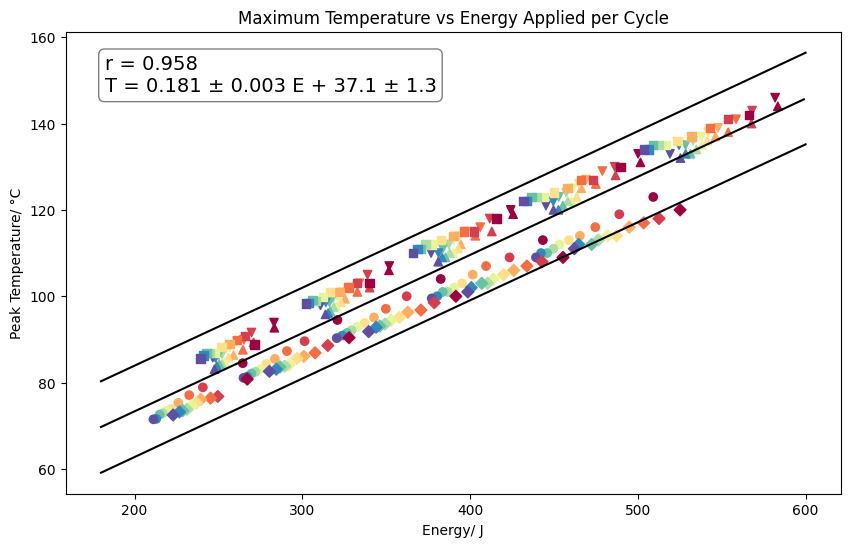

In [74]:
testplot = heatingCurve(calibration_potentiostat_data_low, calibration_temperature_data_low, parameters_low, offsets=[-1,3,0,0])
testplothigh = heatingCurve(calibration_potentiostat_data_high, calibration_temperature_data_high, parameters_high, offsets=[0,0,0,0,0], cycles_wanted=[1,2,3,4,5],colors=["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"])
calibration_line = calibrationLineDraw(calibration_potentiostat_data_low,calibration_temperature_data_low,parameters_low, colors= ["#ff0090","#9e0142","#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#AC8ED9"])    
calibration_line_high = calibrationLineDraw(calibration_potentiostat_data_high,calibration_temperature_data_high,parameters_high)

def testCycling(potentiostat_path_lists,aranet_file,calibration_data, parameters):
    

    output_dictionary ={}

    #create a list of dictionaries of edges found and CO2 data, with one dictionary per sample    
    peaks_lists = [edgePeakFind(potentiostat_path_list,aranet_file, parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of the chronologically corrected potentiostat data dictionaries, with one dictionary per sample
    potentiostat_unstriped_list = [unstripe(potentiostat_path_list,parameters) for potentiostat_path_list in potentiostat_path_lists]

    #create a list of lists of peak currents, one list per sample (with the sublist being one data point per voltage hold)
    current_peak_lists = [peakCurrent(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #create a list of lists of energies per cycle, again one list per cycle (sublists are one datapoint per voltage hold) #
    #this isn't in use as of yet but doesn't slow down the programme very much and could be useful later, feel free to comment it out or remove it entirely
    energy_lists = [findEnergy(potentiostat_dictionary) for potentiostat_dictionary in potentiostat_unstriped_list]

    #using the dictionaries created by peaksFound, find a capacity for each voltage hold. this is dependent on the mass as well. once again, one list per sample, one datapoint per hold
    capacity_lists = [[swing_CO2/mass for swing_CO2 in peaks_found["swingCO2"]] for peaks_found,mass in zip(peaks_lists,parameters["mass"])]

    #you must be getting bored of this by now. now using the peak current and the calibration graph to estimate the temperature for each voltage hold. data structured identically
    #it turns out energy is a better fit, we will comment this out for future use
    #temperature_lists = [[current * calibration_data["current_regression"].slope + calibration_data["current_regression"].intercept for current in current_peak_list] for current_peak_list in current_peak_lists]
    temperature_lists = [[energy * calibration_data["energy_regression"].slope + calibration_data["energy_regression"].intercept for energy in energy_list] for energy_list in energy_lists]

    #something different! now we use the predictionBands formula to calculate the error in the temperature
    #energy still a better fit, still commenting out the current fit
    #temp_bands = predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())
    
    temp_bands = predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])

    #as predictionBands outputs a list of points, this is a tad inelegant. we want to correlate each current to a top and bottom temperature, and to do that we need to make sure the current is in the list
    #we do this by rounding the current and the prediction bands as well to two significant figures (rounding error is negligeable) and making sure the predictionBand covers all possible points under that constraint 
    #and again
    #rounded_band_current = [round(x, 2) for x in predictionBands(calibration_data["current_array"].flatten(), calibration_data["temperature_array"].flatten())[0]]
    rounded_band_energy = [round(x, 2) for x in predictionBands(calibration_data["energy_array"].flatten(), calibration_data["temperature_array"].flatten(), xlim=[200,600])[0]]

    #using those rounded currents, we find the bandwidth at that point and use that as the error. one list per sample, one point per hold, again 
    temperature_error_lists = [[(temp_bands[2][rounded_band_energy.index(round(energy,2))] - temp_bands[1][rounded_band_energy.index(round(energy,2))])/2 for energy in energy_list] for energy_list in energy_lists]
    
    output_dictionary["peaks lists"] = peaks_lists
    output_dictionary["potentiostat unstriped list"] = potentiostat_unstriped_list
    output_dictionary["current peak lists"] = current_peak_lists
    output_dictionary["energy lists"] = energy_lists
    output_dictionary["capacity lists"] = capacity_lists
    output_dictionary["temperature lists"] = temperature_lists
    output_dictionary["temp bands"] = temp_bands
    output_dictionary["rounded band energy"] = rounded_band_energy
    output_dictionary["temperature error lists"] = temperature_error_lists

    return output_dictionary

test_analysis_cycling = testCycling(test_potentiostat_data_low,test_aranet_data_low,calibration_data_low,test_params_low)
test_analysis_cycling_high = testCycling(test_potentiostat_data_high,test_aranet_data_high,calibration_data_high,test_params_high)


findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype


[range(180, 600), [75.91535372444099, 76.09895057834046, 76.28254743223997, 76.46614428613944, 76.64974114003894, 76.83333799393841, 77.0169348478379, 77.20053170173739, 77.38412855563688, 77.56772540953637, 77.75132226343584, 77.93491911733534, 78.11851597123481, 78.30211282513432, 78.48570967903379, 78.66930653293328, 78.85290338683276, 79.03650024073225, 79.22009709463174, 79.40369394853123, 79.58729080243072, 79.77088765633019, 79.95448451022969, 80.13808136412916, 80.32167821802867, 80.50527507192814, 80.68887192582763, 80.87246877972711, 81.0560656336266, 81.23966248752609, 81.42325934142556, 81.60685619532507, 81.79045304922454, 81.97404990312404, 82.15764675702351, 82.341243610923, 82.52484046482249, 82.70843731872198, 82.89203417262146, 83.07563102652095, 83.25922788042044, 83.44282473431991, 83.62642158821942, 83.81001844211889, 83.99361529601838, 84.17721214991786, 84.36080900381735, 84.54440585771684, 84.72800271161633, 84.91159956551581, 85.09519641941529, 85.2787932733147

findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype


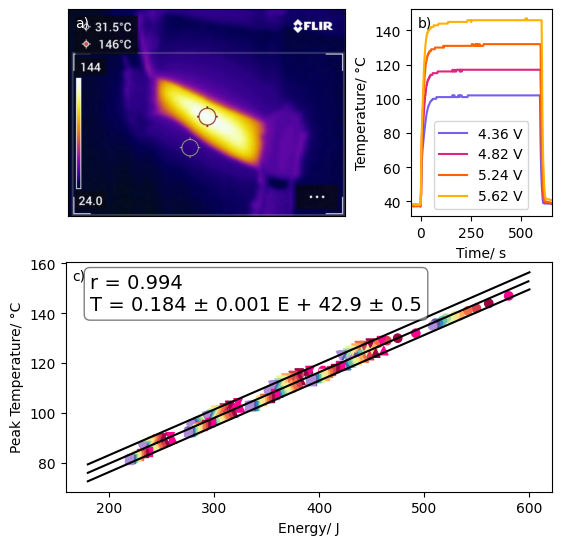

'fig,ax = plt.subplots(figsize = (10,6))\n\n    ax.set_title("Maximum Temperature vs Energy Applied per Cycle")\n\n    ax.set_xlabel("Energy/ J")\n    ax.set_ylabel("Peak Temperature/ °C")\n\n    props = dict(boxstyle=\'round\', facecolor=\'white\', alpha=0.5)\n    box_text = ("r = " + str(round(calibration_dictionary["energy_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_dictionary["energy_regression"].slope,3)) + " ± " + str(round(calibration_dictionary["energy_regression"].stderr,3)) + " E + " + str(round(calibration_dictionary["energy_regression"].intercept,1)) +" ± " + str(round(calibration_dictionary["energy_regression"].intercept_stderr,1))\n    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment=\'top\', bbox=props, family = "Serif")\n\n    fit_line_x = range(180, 600, 1)\n    fit_line_y = [calibration_dictionary["energy_regression"].slope * x + calibration_dictionary["energy_regression"].intercept for x in fit_line_x]\n    ax.

In [75]:
#hacking out more graphs
print(calibration_line)

def gridplot(columns,rows, size, plots):
    fig,ax = plt.subplot_mosaic([["a)","b)"],["c)","c)"]], figsize = size, width_ratios=[2,1],height_ratios=[1.8,2])
   
    #horizontal_position = plotnum%columns
    #vertical_position = plotnum//columns
    heat_map = image.imread(r"/media/kp556/thlirth/heat_map.png")
    ax["a)"].imshow(heat_map)
    ax["a)"].set_xticks([])
    ax["a)"].set_yticks([])
    plt.subplots_adjust(wspace=0.3, hspace=0.21)
    small_time,small_temp = testplot
    print(len(small_time))
    counter = 0
    colors = ["#785EF0","#DC267F","#FE6100","#FFB000"]
    legends = ["4.36 V","4.82 V","5.24 V","5.62 V"]
    for small_time1,small_temp1 in zip(small_time,small_temp):
            
            
        ax["b)"].plot(small_time1,small_temp1, c = colors[counter], label = legends[counter])
        ax["b)"].set_xlim(left = -50, right = 650)
        ax["b)"].set_xlabel("Time/ s")
        ax["b)"].set_ylabel("Temperature/ °C")
        counter += 1
    ax["b)"].legend()




    shapes = ["o", "^", "v", "s", "D"]
    colors= ["#ff0090","#9e0142","#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#AC8ED9"]
    ax["c)"].plot(calibration_line[0],calibration_line[1], c = "black")
    ax["c)"].plot(calibration_line[4],calibration_line[2], c = "black")
    ax["c)"].plot(calibration_line[4],calibration_line[3], c = "black")
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("r = " + str(round(calibration_line[5]["energy_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_line[5]["energy_regression"].slope,3)) + " ± " + str(round(calibration_line[5]["energy_regression"].stderr,3)) + " E + " + str(round(calibration_line[5]["energy_regression"].intercept,1)) +" ± " + str(round(calibration_line[5]["energy_regression"].intercept_stderr,1))
    ax["c)"].text(0.05, 0.95, box_text, transform=ax["c)"].transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")

    ax["c)"].set_xlabel("Energy/ J")
    ax["c)"].set_ylabel("Peak Temperature/ °C")
    for x in range(len(calibration_line[5]["temperature_array"])):
        ax["c)"].scatter(calibration_line[5]["energy_array"][x].flatten(), calibration_line[5]["temperature_array"][x].flatten(), c = colors*int(len(calibration_line[5]["energy_array"][x].flatten())/len(colors)), marker = shapes[x])


    for label, ax1 in ax.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
        if label =="a)":
            
            ax1.annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            color = "white")
        else:
            ax1.annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize='medium', verticalalignment='top', fontfamily='serif',
             color = "black")
        

    
    
    plt.show()

gridplot(2,2,(6.2677,6.2677),[0,1,2])
"""fig,ax = plt.subplots(figsize = (10,6))

    ax.set_title("Maximum Temperature vs Energy Applied per Cycle")

    ax.set_xlabel("Energy/ J")
    ax.set_ylabel("Peak Temperature/ °C")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("r = " + str(round(calibration_dictionary["energy_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_dictionary["energy_regression"].slope,3)) + " ± " + str(round(calibration_dictionary["energy_regression"].stderr,3)) + " E + " + str(round(calibration_dictionary["energy_regression"].intercept,1)) +" ± " + str(round(calibration_dictionary["energy_regression"].intercept_stderr,1))
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props, family = "Serif")

    fit_line_x = range(180, 600, 1)
    fit_line_y = [calibration_dictionary["energy_regression"].slope * x + calibration_dictionary["energy_regression"].intercept for x in fit_line_x]
    ax.plot(fit_line_x,fit_line_y, c = "black")

    upper_bound_y = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600])[2]
    lower_bound_y = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600])[1]
    bounds_x = predictionBands(calibration_dictionary["energy_array"].flatten(),calibration_dictionary["temperature_array"].flatten(), xlim = [180,600] )[0]
    ax.plot(bounds_x,lower_bound_y, c = "black")
    ax.plot(bounds_x,upper_bound_y, c = "black")  
    for x in range(len(calibration_dictionary["temperature_array"])):
        ax.scatter(calibration_dictionary["energy_array"][x].flatten(), calibration_dictionary["temperature_array"][x].flatten(), c = colors*int(len(calibration_dictionary["energy_array"][x].flatten())/len(colors)), marker = shapes[x])

    energy_path = os.path.join(save_path,"Energy Calibration Graph.png")

    plt.savefig(energy_path)
    plt.show()
    return [fit_line_x, fit_line_y, upper_bound_y, lower_bound_y, bounds_x, calibration_dictionary]"""

[1725281395.4285, 1725281400.4285, 1725281405.4283, 1725281410.4283, 1725281415.4283, 1725281420.4283, 1725281425.4283, 1725281430.4283, 1725281435.4283, 1725281440.4283, 1725281445.4283, 1725281450.4283, 1725281455.4283, 1725281460.4283, 1725281465.4283, 1725281470.4283, 1725281475.4283, 1725281480.4283, 1725281485.4283, 1725281490.4283, 1725281495.4283, 1725281500.4283, 1725281505.4283, 1725281510.4283, 1725281515.4283, 1725281520.4283, 1725281525.4283, 1725281530.4283, 1725281535.4283, 1725281540.4283, 1725281545.4283, 1725281550.4283, 1725281555.4283, 1725281560.4283, 1725281565.4283, 1725281570.4283, 1725281575.4283, 1725281580.4283, 1725281585.4283, 1725281590.4283, 1725281595.4283, 1725281600.4283, 1725281605.4283, 1725281610.4283, 1725281615.4283, 1725281620.4283, 1725281625.4283, 1725281630.4283, 1725281635.4283, 1725281640.4283, 1725281645.4283, 1725281650.4283, 1725281655.4283, 1725281660.4283, 1725281665.4283, 1725281670.4283, 1725281675.4283, 1725281680.4283, 1725281685.42

findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype


[[95.77744196653038, 110.17953513830577, 125.26721604450213, 140.46533871274266, 95.37050706521785, 108.72676956426878, 123.08041704080563, 137.9881894012787, 94.30311102215761, 107.34880250715206, 121.54641017811164, 136.08631918306966, 93.42555641291061, 106.43031412191938, 120.3626696212273, 134.6962532387259, 92.81122741480027, 105.68310654240317, 119.48116186042098, 133.63442181729502, 92.31111698033166, 105.06126573727363, 118.72269183034544, 132.76414856448923, 91.90818341994965, 104.5811539082267, 118.15325442854848, 132.03108635386673, 91.53778288717281, 104.11353376759631, 117.61849053783861, 131.45015959568286, 91.2760778931908, 103.79816793250717, 117.22353616281261, 130.92459744211538, 90.99838040176681, 103.46209709209573, 116.79822125814357, 130.44717238006828, 90.74646030282099, 103.10295565120728, 116.3675283731001, 129.92105663880545, 90.50259359206808, 102.82750819404279, 115.99740003912709, 129.50163453613055]]


findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype
findfont: Generic family 'serif' not found because none of the following families were found: Palatino Linotype


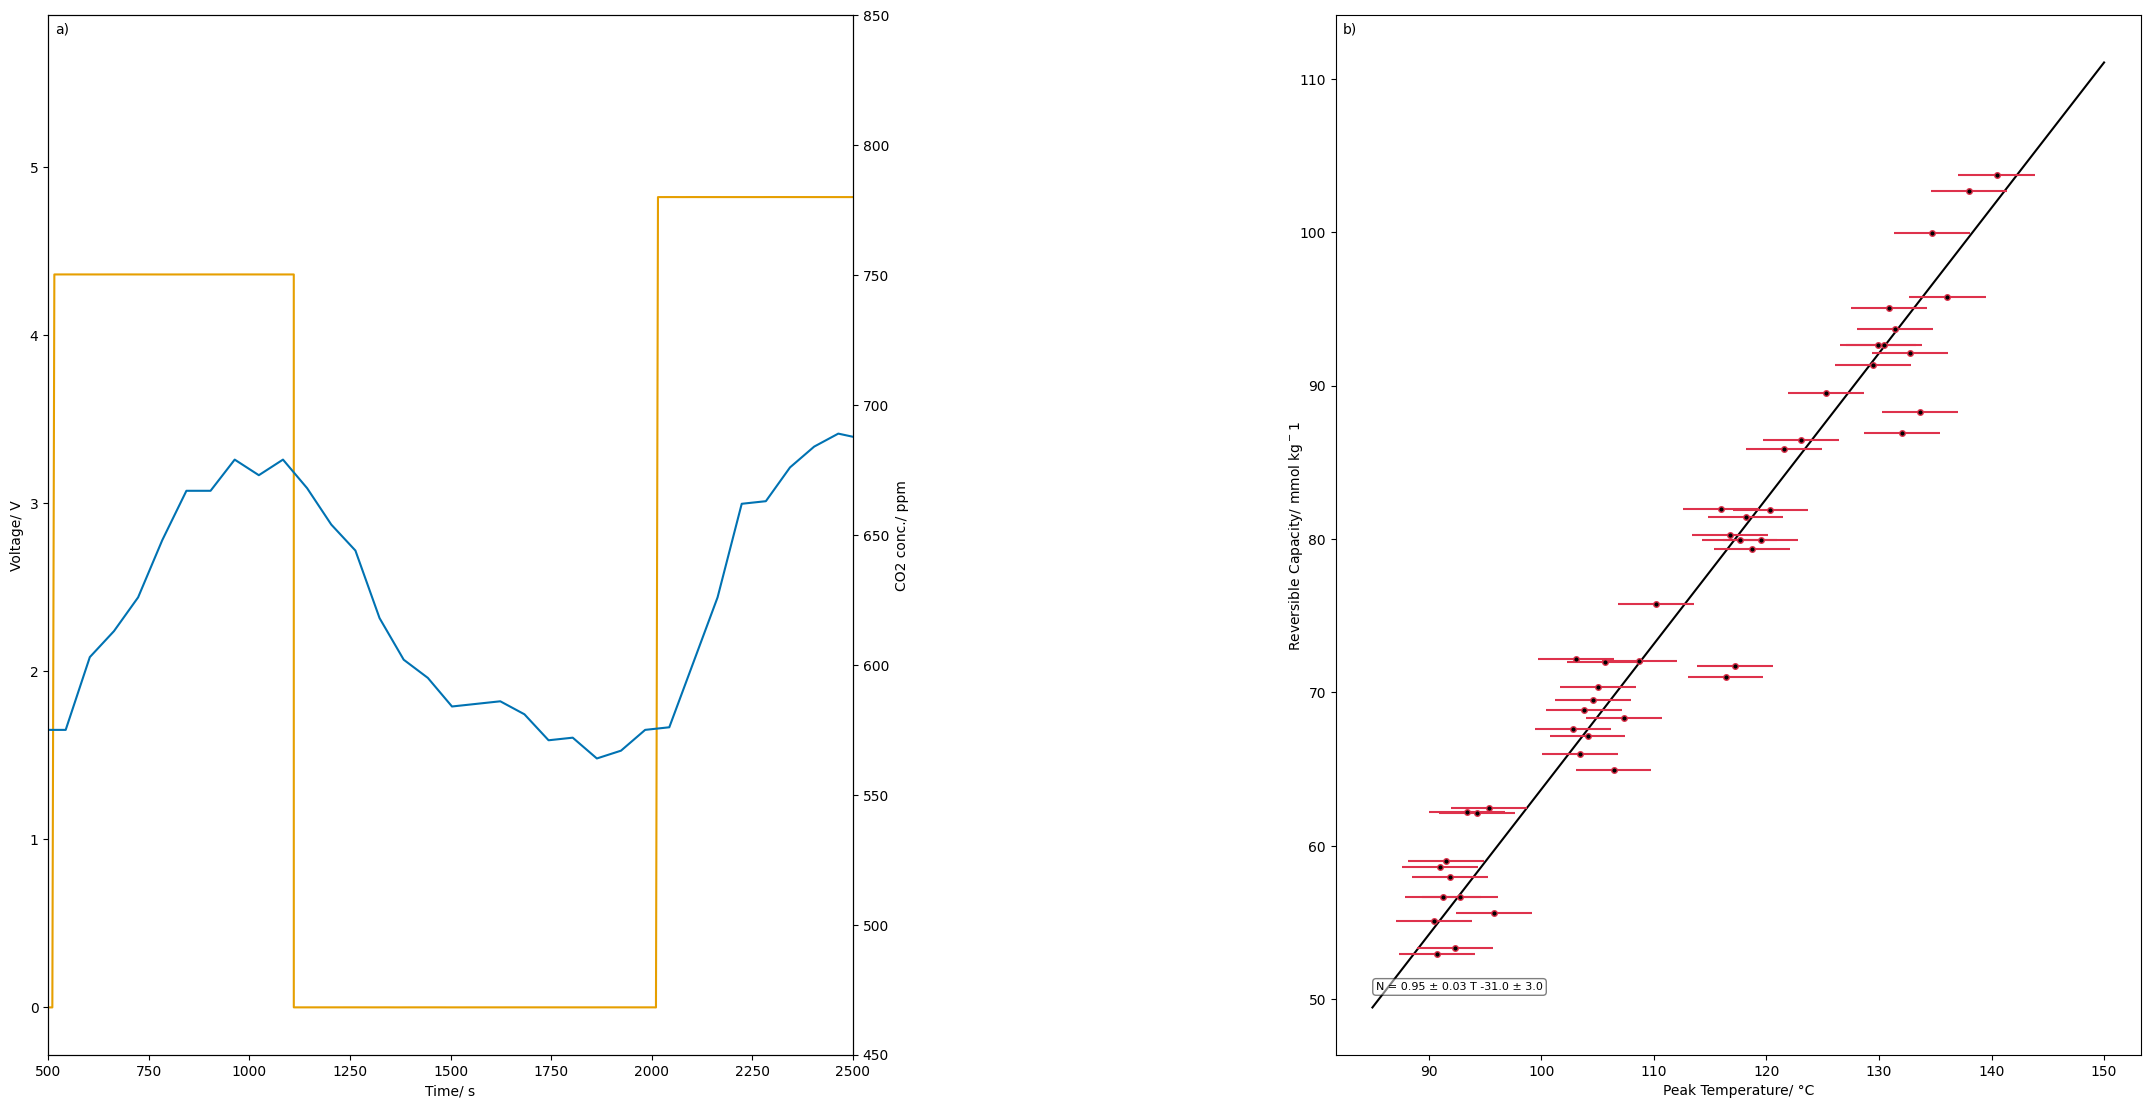

In [76]:
print([datetime.datetime.timestamp(x) for x in readPotentiostat(test_potentiostat_data_low[0])["potentiostat_time"]])
def mozaic2(size):
    y= 0
    
    fig, ax = plt.subplot_mosaic([["a)","b)"]], figsize = (size,size/2))
    plt.subplots_adjust(wspace=0.6)
    unstriped = unstripe(test_potentiostat_data_low[y],parameters_low)
    start_time = datetime.datetime.timestamp(readPotentiostat(test_potentiostat_data_low[y])["potentiostat_time"][y])+11500
    ax2 = ax["a)"].twinx()
    ax2.set_ylim(top=850, bottom=450)
    ax["a)"].plot([datetime.datetime.timestamp(x)-start_time for x in unstriped["potentiostat_time"]], unstriped["voltage"], c = "#E69F00")
    ax2.plot([datetime.datetime.timestamp(x)-start_time for x in readAranet(test_aranet_data_low)["aranet_time"]],readAranet(test_aranet_data_low)["ppm"], c = "#0072B2")
    ax["a)"].set_xlim(left= 500, right = 2500)

    ax["a)"].set_xlabel("Time/ s")
    ax["a)"].set_ylabel("Voltage/ V")
    ax2.set_ylabel("CO2 conc./ ppm")

    def f(y,m,b):
        return ((y-b)/m)

    print([test_analysis_cycling["temperature lists"][0]])
    fit,cov_fit = scipy.optimize.curve_fit(f, [capacity_mol_mg*1000000000 for capacity_mol_mg in sum([test_analysis_cycling["capacity lists"][0]], [])], sum([test_analysis_cycling["temperature lists"][0]], []), sigma = sum([test_analysis_cycling["temperature error lists"][0]], []), absolute_sigma = True)
    fit_err = np.sqrt(np.diag(cov_fit))
    px = np.linspace(85, 150, 20000)
    py = [fit[0]*x+fit[1] for x in px]

    ax["b)"].plot(px,py, c = "black")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("N = " + str(round(fit[0],2)) + " ± " + str(round(fit_err[0],2)) + " T " + str(round(fit[1],0)) + " ± " + str(round(fit_err[1],0)))
    ax["b)"].text(0.05, 0.07, box_text, transform=ax["b)"].transAxes, fontsize=8, verticalalignment='top', bbox=props, family = "Serif")

    ax["b)"].errorbar(test_analysis_cycling["temperature lists"][0], [capacity_mol_mg *1000000000 for capacity_mol_mg in test_analysis_cycling["capacity lists"][0]], c = "#de324c", xerr= test_analysis_cycling["temperature error lists"][0], linestyle = "None", marker = "o", mfc = "black", mec = "#de324c", ms = 4 )
    ax["b)"].set_xlabel("Peak Temperature/ °C")

    ax["b)"].set_ylabel("Reversible Capacity/ mmol kg$^-1$ ", labelpad=-4)

    for label, ax1 in ax.items():
    # Use Axes.annotate to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes.
    
        ax1.annotate(
        label,
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',
        color = "black")
    

    plt.show()

mozaic2(27)

findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


5
[[84.92180395750484, 96.22120297738016, 108.1539481709537, 120.09249789850996, 82.89341578318079, 94.5186404180073, 106.32305702790518, 118.18231123846459, 81.9720334630338, 93.41182451721608, 105.05212413784967, 116.92754849625354, 81.36556276117551, 92.67211370395052, 104.22692452932932, 115.91511645201066, 80.79334642103356, 91.99994939895747, 103.44487028121185, 115.01209955721772, 80.32797373075158, 91.46148605149463, 102.82232050697597, 114.38858889266257, 79.97239644965617, 90.98876369271386, 102.26697511293322, 113.70298078904744, 79.60700107558712, 90.54899085093096, 101.73299908961997, 113.14745042346, 79.3092362731056, 90.14952085806068, 101.2724242560623, 112.52555690550288, 78.99455633591856, 89.74970790700206, 100.78595391519929, 112.0015400153889, 78.677624316102, 89.38570503307454, 100.3780472855764, 111.56481813606925, 78.40702237326548, 89.04897344594882, 100.0227887896875, 111.12871779245161]]


findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.
findfont: Font family 'Serif' not found.


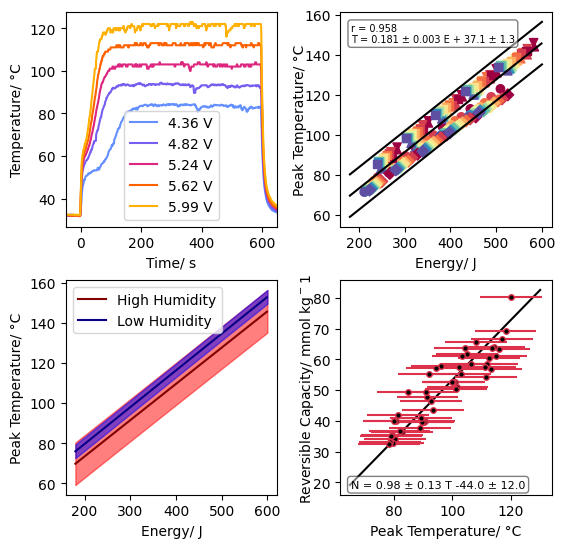

In [77]:
def mozaic3(size):
    fig, ax = plt.subplot_mosaic([["a)","b)"],["c)","d)"]], figsize = (size,size))
    plt.subplots_adjust(wspace=0.3,hspace=0.25)
    small_time,small_temp = testplothigh
    print(len(small_time))
    counter = 0
    colors = ["#648FFF","#785EF0","#DC267F","#FE6100","#FFB000"]
    legends = ["4.36 V","4.82 V","5.24 V","5.62 V","5.99 V"]
    for small_time1,small_temp1 in zip(small_time,small_temp):
            
            
        ax["a)"].plot(small_time1,small_temp1, c = colors[counter], label = legends[counter])
        ax["a)"].set_xlim(left = -50, right = 650)
        ax["a)"].set_xlabel("Time/ s")
        ax["a)"].set_ylabel("Temperature/ °C")
        counter += 1
    ax["a)"].legend()


    shapes = ["o", "^", "v", "s", "D"]
    colors= ["#9e0142","#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
    ax["b)"].plot(calibration_line_high[0],calibration_line_high[1], c = "black")
    ax["b)"].plot(calibration_line_high[4],calibration_line_high[2], c = "black")
    ax["b)"].plot(calibration_line_high[4],calibration_line_high[3], c = "black")
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("r = " + str(round(calibration_line_high[5]["energy_regression"].rvalue,3))) + "\n" + "T = " + str(round(calibration_line_high[5]["energy_regression"].slope,3)) + " ± " + str(round(calibration_line_high[5]["energy_regression"].stderr,3)) + " E + " + str(round(calibration_line_high[5]["energy_regression"].intercept,1)) +" ± " + str(round(calibration_line_high[5]["energy_regression"].intercept_stderr,1))
    ax["b)"].text(0.05, 0.95, box_text, transform=ax["b)"].transAxes, fontsize=7, verticalalignment='top', bbox=props, family = "Serif")

    ax["b)"].set_xlabel("Energy/ J")
    ax["b)"].set_ylabel("Peak Temperature/ °C", labelpad= -2)
    for x in range(len(calibration_line_high[5]["temperature_array"])):
        ax["b)"].scatter(calibration_line_high[5]["energy_array"][x].flatten(), calibration_line_high[5]["temperature_array"][x].flatten(), c = colors*int(len(calibration_line_high[5]["energy_array"][x].flatten())/len(colors)), marker = shapes[x])


    ax["c)"].fill_between(calibration_line_high[4],calibration_line_high[2],calibration_line_high[3], color = "r",alpha =0.5)
    ax["c)"].fill_between(calibration_line[4],calibration_line[2],calibration_line[3], color = "b", alpha = 0.5)
    ax["c)"].plot(calibration_line_high[0],calibration_line_high[1], c = "#800000", label= "High Humidity")
    ax["c)"].plot(calibration_line[0],calibration_line[1], c = "#090088", label = "Low Humidity")
    ax["c)"].set_xlabel("Energy/ J")
    ax["c)"].set_ylabel("Peak Temperature/ °C")
    ax["c)"].legend()

    def f(y,m,b):
        return ((y-b)/m)

    print([test_analysis_cycling_high["temperature lists"][0]])
    fit,cov_fit = scipy.optimize.curve_fit(f, [capacity_mol_mg*1000000000 for capacity_mol_mg in sum([test_analysis_cycling_high["capacity lists"][0]], [])], sum([test_analysis_cycling_high["temperature lists"][0]], []), sigma = sum([test_analysis_cycling_high["temperature error lists"][0]], []), absolute_sigma = True)
    fit_err = np.sqrt(np.diag(cov_fit))
    px = np.linspace(65, 130, 20000)
    py = [fit[0]*x+fit[1] for x in px]

    ax["d)"].plot(px,py, c = "black")

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    box_text = ("N = " + str(round(fit[0],2)) + " ± " + str(round(fit_err[0],2)) + " T " + str(round(fit[1],0)) + " ± " + str(round(fit_err[1],0)))
    ax["d)"].text(0.05, 0.07, box_text, transform=ax["d)"].transAxes, fontsize=8, verticalalignment='top', bbox=props, family = "Serif")

    ax["d)"].errorbar(test_analysis_cycling_high["temperature lists"][0], [capacity_mol_mg *1000000000 for capacity_mol_mg in test_analysis_cycling_high["capacity lists"][0]], c = "#de324c", xerr= test_analysis_cycling_high["temperature error lists"][0], linestyle = "None", marker = "o", mfc = "black", mec = "#de324c", ms = 4 )
    ax["d)"].set_xlabel("Peak Temperature/ °C")

    ax["d)"].set_ylabel("Reversible Capacity/ mmol kg$^-1$ ", labelpad=-2)
    
    

    plt.show()



mozaic3(6.2677)